# FOOTPRINTS

In [1]:
import numpy as np
import datetime
from datetime import date
import json
import pylab
import pandas as pd
import matplotlib.pyplot as plt
import os, sys

## Preparacion de datos

### Cargando datos

In [2]:

def leer_data():
    outfile='./SOURCES/data.csv'
    data = pd.read_csv(outfile)
    return data

data_original = leer_data()
data_original.head(3)

client_id                 date   año  mes  dia  hora  \
0  NNeQwQy9MAQ=  2016-07-15 22:23:25  2016    7   15    22   
1  qFRoPHPOc/I=  2016-06-21 21:30:55  2016    6   21    21   
2  qFRoPHPOc/I=  2017-02-01 01:29:59  2017    2    1     1   

  merchant_departement merchant_province     merchant_district   mcc  mccg  \
0                 LIMA              LIMA  San Juan De Luriganc  7994     2   
1                 LIMA              LIMA  San Juan De Luriganc  7994     2   
2                 LIMA              LIMA  San Juan De Luriganc  7994     2   

   client_age  quantity  amount_sol dia_semana        turno  
0        33.0         1       100.0        Fri      4-Noche  
1        52.0         1        20.0       Tues      4-Noche  
2        52.0         1       100.0       Weds  1-Madrugada

### Preparacion de datos

In [3]:
data = data_original[['client_id','mccg','date','año','mes','dia','hora','quantity','amount_sol']]
data.head(3)   

client_id  mccg                 date   año  mes  dia  hora  quantity  \
0  NNeQwQy9MAQ=     2  2016-07-15 22:23:25  2016    7   15    22         1   
1  qFRoPHPOc/I=     2  2016-06-21 21:30:55  2016    6   21    21         1   
2  qFRoPHPOc/I=     2  2017-02-01 01:29:59  2017    2    1     1         1   

   amount_sol  
0       100.0  
1        20.0  
2       100.0

### Definimos los MCCG de esta data

In [4]:
mccg = data.groupby(['mccg']).min().index.values
mccg

array([ 2,  3,  4,  5,  6,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       21, 22, 23, 25, 26, 27, 28])

# FOOTPRINT PARA CADA MCCG

## Unidad de TXs temporales (U)

### Funciones

In [5]:
# definimos los 4 time_windows que usaremos

def time_window(hora):
    tw = 9999
    if hora >=0:
        tw = 0      # Madrugada
    if hora >=6:
        tw = 1      # Mañana
    if hora >=12:
        tw = 2      # Tarde
    if hora >=18:
        tw = 3      # Noche
    return tw

In [6]:
# Definimos los U 

def procesar_u(user):    
    uid=list(user['client_id'])[0]
    
    # Lista los años en que tiene txs el usuario
    years = set(list(user['año']))
    anni = {year:{} for year in list(years)}
    
    # para cada fila (para cada fecha)
    for dat in  range(0,len(user)):
        año = user.iloc[dat]['año']
        week=datetime.datetime(año,user.iloc[dat]['mes'],user.iloc[dat]['dia']).isocalendar()[1]
        weekday=datetime.datetime(año,user.iloc[dat]['mes'],user.iloc[dat]['dia']).weekday()
        turn = time_window(user.iloc[dat]['hora'])
        
        # Si la semana no existe en el año
        if not(week in anni[año]):
            anni[año][week] = {}
        # Si el turno no existe en la semana y año
        if not (turn in anni[año][week]):
            anni[año][week][turn]=np.array([0]*7)  #CUATRO TURNOS
            
        anni[año][week][turn][weekday]+=user.iloc[dat]['quantity'] # suma cantidades "importancia por compras"
        #anni[año][week][turn][weekday]+=user.iloc[dat]['amount_sol'] # suma montos "importancia por gastos"
            
    return uid,anni

### Procesando U de cada MCCG

In [7]:
for j in range(len(mccg)):
    print()
    data_temp = data.loc[data['mccg'] == mccg[j]]
    
    path = "RESULTS/MCCG_"+str(mccg[j])
    file_name="mccg_"+str(mccg[j])
    try:
        os.stat(path)
    except:
        os.mkdir(path) 

    file='./%s/%s.json' %(path,file_name)
    
    ##################################################
    #        Procesando U de cada CLIENTE
    ##################################################
    
    # Extraemos la lista de clientes sin repetir
    clientes =  data_temp.groupby('client_id').client_id.count().index
    profiles={}
    
    print("Number of rows "+str(len(data_temp)))
    # Para cada cliente
    for cliente in clientes:
        cliente_i= data_temp[data_temp['client_id'] == cliente]
        ## ejecutamos para cada usuario
        results=procesar_u(cliente_i)
        profiles[results[0]]=results[1]
    
    individual_footprint="%s.individual_footprint" %(file)
    fw=open(individual_footprint,'w')
    fw.write('customer_id,year,week,profile_id,turn,size,d0t0,d1t0,d2t0,d3t0,d4t0,d5t0,d6t0,d0t1,d1t1,d2t1,d3t1,d4t1,d5t1,d6t1,d0t2,d1t2,d2t2,d3t2,d4t2,d5t2,d6t2,d0t3,d1t3,d2t3,d3t3,d4t3,d5t3,d6t3\n')
    footprints=0
    for uid in profiles:
        profile_id=0
        for year in profiles[uid]:
            for week in profiles[uid][year]:
                temp=np.zeros(28)
                for turn in profiles[uid][year][week]:
                    d=profiles[uid][year][week][turn]
                    if(turn == 0):
                        for i in range(0,7):
                            temp[i] += d[i]
                    if(turn == 1):
                        for i in range(7,14):
                            temp[i] += d[i-7]
                    if(turn == 2):
                        for i in range(14,21):
                            temp[i] += d[i-14]
                    if(turn == 3):
                        for i in range(21,28):
                            temp[i] += d[i-21]


                fw.write(''+str(uid)+','+str(year)+','+str(week)+','+str(profile_id)+','+str(turn)+','+str(sum(temp))+','
                         +str(temp[0])+','+str(temp[1])+','+str(temp[2])+','+str(temp[3])+','+str(temp[4])+','+str(temp[5])+','+str(temp[6])+','
                         +str(temp[7])+','+str(temp[8])+','+str(temp[9])+','+str(temp[10])+','+str(temp[11])+','+str(temp[12])+','+str(temp[13])+','
                         +str(temp[14])+','+str(temp[15])+','+str(temp[16])+','+str(temp[17])+','+str(temp[18])+','+str(temp[19])+','+str(temp[20])+','
                         +str(temp[21])+','+str(temp[22])+','+str(temp[23])+','+str(temp[24])+','+str(temp[25])+','+str(temp[26])+','+str(temp[27])
                         +'\n')

                profile_id = profile_id + 1
        footprints+=profile_id
        fw.flush()
    fw.close()
    print ("number of footprint: "+str(footprints))
    print("mccg_"+str(mccg[j])+" Finalizado")


Number of rows 3400
number of footprint: 1836
mccg_2 Finalizado

Number of rows 653
number of footprint: 633
mccg_3 Finalizado

Number of rows 56
number of footprint: 56
mccg_4 Finalizado

Number of rows 11465
number of footprint: 10687
mccg_5 Finalizado

Number of rows 72
number of footprint: 71
mccg_6 Finalizado

Number of rows 12819
number of footprint: 12112
mccg_8 Finalizado

Number of rows 180
number of footprint: 169
mccg_9 Finalizado

Number of rows 9417
number of footprint: 8142
mccg_10 Finalizado

Number of rows 75687
number of footprint: 63298
mccg_11 Finalizado

Number of rows 1455
number of footprint: 1348
mccg_12 Finalizado

Number of rows 6469
number of footprint: 5639
mccg_13 Finalizado

Number of rows 7
number of footprint: 7
mccg_14 Finalizado

Number of rows 71772
number of footprint: 65659
mccg_15 Finalizado

Number of rows 7476
number of footprint: 6823
mccg_16 Finalizado

Number of rows 14000
number of footprint: 11423
mccg_17 Finalizado

Number of rows 76602
num

## Funciones de Apoyo (clusters)

In [8]:
def process_footprint(data,tests,log=False):
    from sklearn.cluster import MiniBatchKMeans
    #KMeans(init='k-means++', n_clusters=k, n_init=10)
    import datetime
    K={}
    for k in tests:
        if k<=len(data):
            if log:
                print("%s: processing %s"%(datetime.datetime.now(),k))
            K[k]=bench_k_means(MiniBatchKMeans(init='k-means++', n_clusters=k, batch_size=100,
                      n_init=10, max_no_improvement=10, verbose=0,
                      random_state=0),name="k-means++", data=data)
    return K

In [9]:
def compute_best_k(x,y,occurrencies, plot=False,points=1000,sf=0.9):
    import numpy as np
    
    if len(x)<5:
        b_k = max(1, round(np.sqrt(occurrencies/2)))
        if plot:
            import pylab
            pylab.plot(x,y)
            pylab.scatter(x[b_k],y[b_k],s=20, marker='o')
            pylab.text(x[b_k],y[b_k],"bestK %s" %(b_k))
            return b_k,pylab

        return b_k
    
    from scipy.interpolate import interp1d
    from scipy.interpolate import UnivariateSpline
    spl = UnivariateSpline(x, y)
    spl.set_smoothing_factor(sf)
    xs = np.linspace(min(x), max(x), points)
    ys = spl(xs)
    idx_better_k=get_change_point(xs, ys)
    if plot:
        import pylab
        pylab.plot(xs,ys)
        
        pylab.scatter(xs[idx_better_k],ys[idx_better_k],s=20, marker='o')
        pylab.text(xs[idx_better_k],ys[idx_better_k],"bestK %s" %(np.round(xs[idx_better_k])))
        return int(np.round(xs[idx_better_k])),pylab
    return int(np.round(xs[idx_better_k]))

In [10]:
def bench_k_means(estimator, name, data,distance_function=None):
    from sklearn import metrics
    from sklearn.metrics import silhouette_samples, silhouette_score
    import time
    t0 = time.time()
    if distance_function:
        estimator.fit(data,distance_function)
    else:
        estimator.fit(data)
    #cluster_labels = estimator.fit_predict(data)
    #silhouette_score_ = silhouette_score(data, cluster_labels)
    
    inertia=estimator.inertia_
    duration=time.time() - t0
    return {'inertia':inertia,'duration':duration, 'estimator':estimator}#,'silhouette':silhouette_score_}

def get_change_point(x, y):
    """
         Elección del mejor K
         :: param x: lista de valores de K
         :: param y: lista de valores de SSE
    """
    import math
    max_d = -float('infinity')
    index = 0

    for i in range(0, len(x)):
        c = closest_point_on_segment(a=[x[0], y[0]], b=[x[len(x)-1], y[len(y)-1]], p=[x[i], y[i]])
        d = math.sqrt((c[0]-x[i])**2 + (c[1]-y[i])**2)
        if d > max_d:
            max_d = d
            index = i
    
    return index

def closest_point_on_segment(a, b, p):
    sx1 = a[0]
    sx2 = b[0]
    sy1 = a[1]
    sy2 = b[1]
    px = p[0]
    py = p[1]

    x_delta = sx2 - sx1
    y_delta = sy2 - sy1

    if x_delta == 0 and y_delta == 0:
        return p

    u = ((px - sx1) * x_delta + (py - sy1) * y_delta) / (x_delta * x_delta + y_delta *  y_delta)
    if u < 0:
        closest_point = a
    elif u > 1:
        closest_point = b
    else:
        cp_x = sx1 + u * x_delta
        cp_y = sy1 + u * y_delta
        closest_point = [cp_x, cp_y]

    return closest_point
	

## Clusters Individuales (f)

In [11]:
# Extraemos la lista de clientes sin repetir

def leer_data(outfile):
    data = pd.read_csv(outfile)
    return data

In [12]:
# Para cada mccg

for i in range(len(mccg)):
    path = "RESULTS/MCCG_"+str(mccg[i])
    file='./%s/mccg_%s.json' %(path,mccg[i])
    print("Para el Mccg ",mccg[i])
    
    individual_footprint="%s.individual_footprint" %(file)
    individual_clusters="%s.clusters" %(individual_footprint)
    individual_labels="%s.labels" %(individual_footprint)

    # Extraemos la lista de clientes sin repetir
    data_temp = pd.read_csv(individual_footprint)
    clientes =  data_temp.groupby('customer_id').customer_id.count().index
    
    # Numero de filas del archivo
    f=open(individual_footprint)
    num_rows = len(f.readlines())-1
    f.close()

    #<customer_id;year;week;profile_id;size;t1... tn >
    import datetime
    f=open(individual_footprint)
    fw=open(individual_clusters,'w')  #uid,cluster_id,centroid
    fw2=open(individual_labels,'w') #uid,year,week,cluster_id,profile
    fw.write('customer_tag;individual_cluster;d0t0;d1t0;d2t0;d3t0;d4t0;d5t0;d6t0;d0t1;d1t1;d2t1;d3t1;d4t1;d5t1;d6t1;d0t2;d1t2;d2t2;d3t2;d4t2;d5t2;d6t2;d0t3;d1t3;d2t3;d3t3;d4t3;d5t3;d6t3\n')
    fw2.write('customer_tag;year;week;individual_cluster;d0t0;d1t0;d2t0;d3t0;d4t0;d5t0;d6t0;d0t1;d1t1;d2t1;d3t1;d4t1;d5t1;d6t1;d0t2;d1t2;d2t2;d3t2;d4t2;d5t2;d6t2;d0t3;d1t3;d2t3;d3t3;d4t3;d5t3;d6t3\n')

    f.readline()
    data=[] #buffer

    footprints_clustered=0
    footprints_clusters=0
    n_cliente=0
    contador = 0
    temporal= 0
    for row in f: #reading individual footprint
        row=row.strip().split(',') # leemos cada elemento da linea parseada por ","
        uid=row[0]
        year=row[1]
        week=row[2]
        size=float(row[5])
        profile=np.array([float(el) for el in row[6:]])
        # Individual clustering
        if uid==clientes[n_cliente]: # Para cada fila donde los "uid" son iguales 
            data.append(((uid,year,week),profile))     
            contador+=1
        else: #final de cliente
            #---------------------------------------------------------------------
            # procesar data
            #---------------------------------------------------------------------
            to_cluster=[el[1] for el in data]
            K=process_footprint(to_cluster,np.arange(1,len(to_cluster)+1))

            # choose k
            x=list(K.keys())
            y=[K[k]['inertia'] for k in K]
            best_k=compute_best_k(x,y,len(to_cluster))
            #print(str(contador)+' => clustering: '+str(clientes[n_cliente])+' len data: '+str(len(data))+" best k: "+str(best_k))

            # clustering
            if best_k==1:
                #to few records
                cluster_centers_=[np.average(to_cluster,axis=0)]
                labels_=[0]*len(to_cluster)  
            else:
                cluster_centers_=K[best_k]['estimator'].cluster_centers_
                labels_=K[best_k]['estimator'].labels_

            #export individual centroids
            for i in np.arange(len(cluster_centers_)):
                string="%s;%s;%s\n"%(clientes[n_cliente],i,';'.join([str(el) for el in cluster_centers_[i]])) #uid,cluster_id,centroid
                fw.write(string)
                footprints_clusters+=1
            fw.flush()

            #export original data and labels
            for i in np.arange(len(data)):
                uid2=data[i][0]
                profile2=data[i][1]
                label2=labels_[i]
                string="%s;%s;%s;%s;%s\n" %(uid2[0],uid2[1],uid2[2],label2
                                                        ,';'.join([str(el) for el in profile2]))#uid,year,week,cluster_id,profile
                fw2.write(string)
                footprints_clustered+=1
            fw2.flush()
            #---------------------------------------------------------------------
            #---------------------------------------------------------------------



            data=[] #buffer
            data.append(((uid,year,week),profile))

            contador+=1
            temporal+=1
            n_cliente+=1

        if contador == num_rows:        # Para el ultimo cliente y ultima fila
            #---------------------------------------------------------------------
            # procesar data
            #---------------------------------------------------------------------
            to_cluster=[el[1] for el in data]
            K=process_footprint(to_cluster,np.arange(1,len(to_cluster)+1))

            # choose k
            x=list(K.keys())
            y=[K[k]['inertia'] for k in K]
            best_k=compute_best_k(x,y,len(to_cluster))
            #print(str(contador)+' => clustering: '+str(clientes[n_cliente])+' len data: '+str(len(data))+" best k: "+str(best_k))

            # clustering
            if best_k==1:
                #to few records
                cluster_centers_=[np.average(to_cluster,axis=0)]
                labels_=[0]*len(to_cluster)  
            else:
                cluster_centers_=K[best_k]['estimator'].cluster_centers_
                labels_=K[best_k]['estimator'].labels_

            #export individual centroids
            for i in np.arange(len(cluster_centers_)):
                string="%s;%s;%s\n"%(uid,i,';'.join([str(el) for el in cluster_centers_[i]])) #uid,cluster_id,centroid
                fw.write(string)
                footprints_clusters+=1
            fw.flush()

            #export original data and labels
            for i in np.arange(len(data)):
                uid2=data[i][0]
                profile2=data[i][1]
                label2=labels_[i]
                string="%s;%s;%s;%s;%s\n" %(uid2[0],uid2[1],uid2[2],label2
                                                        ,';'.join([str(el) for el in profile2]))#uid,year,week,cluster_id,profile
                fw2.write(string)
                footprints_clustered+=1
            fw2.flush()
            #---------------------------------------------------------------------
            #---------------------------------------------------------------------

            print("final de MCCG") 

            
print('Done')            
    

Para el Mccg  2
final de MCCG
Para el Mccg  3
final de MCCG
Para el Mccg  4
final de MCCG
Para el Mccg  5
final de MCCG
Para el Mccg  6
final de MCCG
Para el Mccg  8
final de MCCG
Para el Mccg  9
final de MCCG
Para el Mccg  10
final de MCCG
Para el Mccg  11
final de MCCG
Para el Mccg  12
final de MCCG
Para el Mccg  13
final de MCCG
Para el Mccg  14
final de MCCG
Para el Mccg  15
final de MCCG
Para el Mccg  16
final de MCCG
Para el Mccg  17
final de MCCG
Para el Mccg  18
final de MCCG
Para el Mccg  19


/home/jkn/anaconda3/lib/python3.6/site-packages/scipy/interpolate/fitpack2.py:226: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


final de MCCG
Para el Mccg  21
final de MCCG
Para el Mccg  22
final de MCCG
Para el Mccg  23
final de MCCG
Para el Mccg  25
final de MCCG
Para el Mccg  26
final de MCCG
Para el Mccg  27
final de MCCG
Para el Mccg  28
final de MCCG
Done


## Clusters Colectivos (g)

Para el Mccg  2
2018-09-03 20:46:52.513193: processing 1
2018-09-03 20:46:52.520910: processing 2
2018-09-03 20:46:52.530995: processing 3
2018-09-03 20:46:52.544634: processing 4
2018-09-03 20:46:52.561299: processing 5
2018-09-03 20:46:52.577127: processing 6
2018-09-03 20:46:52.594309: processing 7
2018-09-03 20:46:52.614126: processing 8
2018-09-03 20:46:52.636008: processing 9
2018-09-03 20:46:52.659947: processing 10
2018-09-03 20:46:52.685746: processing 11
2018-09-03 20:46:52.719820: processing 12
2018-09-03 20:46:52.753432: processing 13
2018-09-03 20:46:52.790443: processing 14
2018-09-03 20:46:52.837188: processing 15
2018-09-03 20:46:52.872833: processing 16
2018-09-03 20:46:52.910658: processing 17
2018-09-03 20:46:52.955494: processing 18
2018-09-03 20:46:53.001286: processing 19
2018-09-03 20:46:53.048580: processing 20
2018-09-03 20:46:53.096354: processing 21
2018-09-03 20:46:53.147540: processing 22
2018-09-03 20:46:53.208423: processing 23
2018-09-03 20:46:53.261920:

/home/jkn/anaconda3/lib/python3.6/site-packages/scipy/interpolate/fitpack2.py:226: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


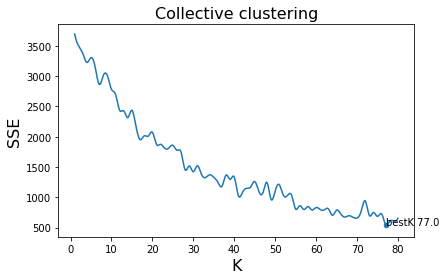

Para el Mccg  3
2018-09-03 20:47:00.901275: processing 1
2018-09-03 20:47:00.909800: processing 2
2018-09-03 20:47:00.920857: processing 3
2018-09-03 20:47:00.934541: processing 4
2018-09-03 20:47:00.950692: processing 5
2018-09-03 20:47:00.969292: processing 6
2018-09-03 20:47:00.990130: processing 7
2018-09-03 20:47:01.013918: processing 8
2018-09-03 20:47:01.041012: processing 9
2018-09-03 20:47:01.071029: processing 10
2018-09-03 20:47:01.111430: processing 11
2018-09-03 20:47:01.145906: processing 12
2018-09-03 20:47:01.190030: processing 13
2018-09-03 20:47:01.237625: processing 14
2018-09-03 20:47:01.292166: processing 15
2018-09-03 20:47:01.350164: processing 16
2018-09-03 20:47:01.409938: processing 17
2018-09-03 20:47:01.459988: processing 18
2018-09-03 20:47:01.524913: processing 19
2018-09-03 20:47:01.592251: processing 20
2018-09-03 20:47:01.648490: processing 21
2018-09-03 20:47:01.714940: processing 22
2018-09-03 20:47:01.782792: processing 23
2018-09-03 20:47:01.852748:

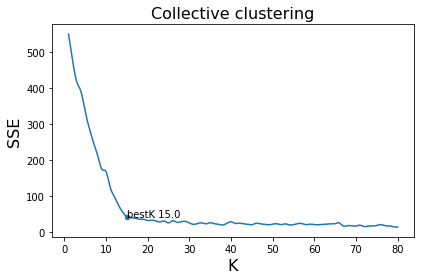

Para el Mccg  4
2018-09-03 20:47:09.804447: processing 1
2018-09-03 20:47:09.815764: processing 2
2018-09-03 20:47:09.826182: processing 3
2018-09-03 20:47:09.838702: processing 4
2018-09-03 20:47:09.852594: processing 5
2018-09-03 20:47:09.868375: processing 6
2018-09-03 20:47:09.886921: processing 7
2018-09-03 20:47:09.907070: processing 8
2018-09-03 20:47:09.926681: processing 9
2018-09-03 20:47:09.949353: processing 10
2018-09-03 20:47:09.971687: processing 11
2018-09-03 20:47:09.995123: processing 12
2018-09-03 20:47:10.022966: processing 13
2018-09-03 20:47:10.057440: processing 14
2018-09-03 20:47:10.096199: processing 15
2018-09-03 20:47:10.134701: processing 16
2018-09-03 20:47:10.185552: processing 17
2018-09-03 20:47:10.236825: processing 18
2018-09-03 20:47:10.291885: processing 19
2018-09-03 20:47:10.346818: processing 20
2018-09-03 20:47:10.404439: processing 21
2018-09-03 20:47:10.462383: processing 22
2018-09-03 20:47:10.514404: processing 23
2018-09-03 20:47:10.568664:

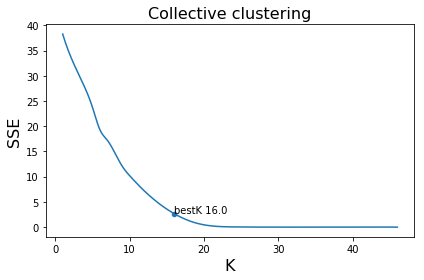

Para el Mccg  5
2018-09-03 20:47:12.495637: processing 1
2018-09-03 20:47:12.512533: processing 2
2018-09-03 20:47:12.529776: processing 3
2018-09-03 20:47:12.549970: processing 4
2018-09-03 20:47:12.576213: processing 5
2018-09-03 20:47:12.629460: processing 6
2018-09-03 20:47:12.661827: processing 7
2018-09-03 20:47:12.696382: processing 8
2018-09-03 20:47:12.763445: processing 9
2018-09-03 20:47:12.835227: processing 10
2018-09-03 20:47:12.878998: processing 11
2018-09-03 20:47:12.926503: processing 12
2018-09-03 20:47:12.977024: processing 13
2018-09-03 20:47:13.029693: processing 14
2018-09-03 20:47:13.084472: processing 15
2018-09-03 20:47:13.189945: processing 16
2018-09-03 20:47:13.306665: processing 17
2018-09-03 20:47:13.428067: processing 18
2018-09-03 20:47:13.499217: processing 19
2018-09-03 20:47:13.566329: processing 20
2018-09-03 20:47:13.641759: processing 21
2018-09-03 20:47:13.716383: processing 22
2018-09-03 20:47:13.793809: processing 23
2018-09-03 20:47:13.872758:

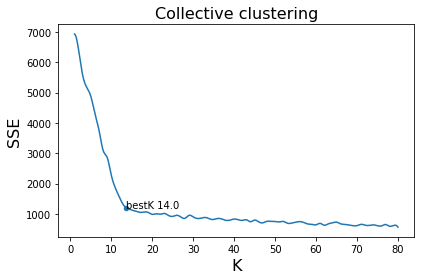

Para el Mccg  6
2018-09-03 20:47:23.781591: processing 1
2018-09-03 20:47:23.788337: processing 2
2018-09-03 20:47:23.800529: processing 3
2018-09-03 20:47:23.813838: processing 4
2018-09-03 20:47:23.827242: processing 5
2018-09-03 20:47:23.841635: processing 6
2018-09-03 20:47:23.858007: processing 7
2018-09-03 20:47:23.874038: processing 8
2018-09-03 20:47:23.896058: processing 9
2018-09-03 20:47:23.919761: processing 10
2018-09-03 20:47:23.942102: processing 11
2018-09-03 20:47:23.973939: processing 12
2018-09-03 20:47:24.006934: processing 13
2018-09-03 20:47:24.047048: processing 14
2018-09-03 20:47:24.088531: processing 15
2018-09-03 20:47:24.126929: processing 16
2018-09-03 20:47:24.166757: processing 17
2018-09-03 20:47:24.212111: processing 18
2018-09-03 20:47:24.256614: processing 19
2018-09-03 20:47:24.308291: processing 20
2018-09-03 20:47:24.358794: processing 21
2018-09-03 20:47:24.423156: processing 22
2018-09-03 20:47:24.497492: processing 23
2018-09-03 20:47:24.559967:

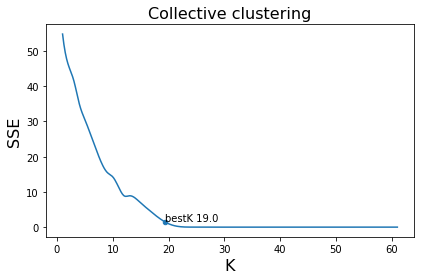

Para el Mccg  8
2018-09-03 20:47:28.345244: processing 1
2018-09-03 20:47:28.366971: processing 2
2018-09-03 20:47:28.396531: processing 3
2018-09-03 20:47:28.422696: processing 4
2018-09-03 20:47:28.455688: processing 5
2018-09-03 20:47:28.489857: processing 6
2018-09-03 20:47:28.541635: processing 7
2018-09-03 20:47:28.580732: processing 8
2018-09-03 20:47:28.641889: processing 9
2018-09-03 20:47:28.730524: processing 10
2018-09-03 20:47:28.798058: processing 11
2018-09-03 20:47:28.869704: processing 12
2018-09-03 20:47:28.924683: processing 13
2018-09-03 20:47:28.983621: processing 14
2018-09-03 20:47:29.089611: processing 15
2018-09-03 20:47:29.176856: processing 16
2018-09-03 20:47:29.268714: processing 17
2018-09-03 20:47:29.337781: processing 18
2018-09-03 20:47:29.408857: processing 19
2018-09-03 20:47:29.530773: processing 20
2018-09-03 20:47:29.673143: processing 21
2018-09-03 20:47:29.768623: processing 22
2018-09-03 20:47:29.835735: processing 23
2018-09-03 20:47:29.904416:

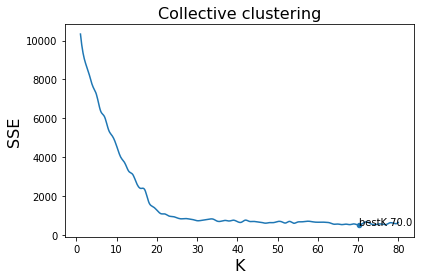

Para el Mccg  9
2018-09-03 20:47:38.936285: processing 1
2018-09-03 20:47:38.942945: processing 2
2018-09-03 20:47:38.951809: processing 3
2018-09-03 20:47:38.962466: processing 4
2018-09-03 20:47:38.976061: processing 5
2018-09-03 20:47:38.991748: processing 6
2018-09-03 20:47:39.007626: processing 7
2018-09-03 20:47:39.027937: processing 8
2018-09-03 20:47:39.053360: processing 9
2018-09-03 20:47:39.078170: processing 10
2018-09-03 20:47:39.107462: processing 11
2018-09-03 20:47:39.134265: processing 12
2018-09-03 20:47:39.166848: processing 13
2018-09-03 20:47:39.199140: processing 14
2018-09-03 20:47:39.232733: processing 15
2018-09-03 20:47:39.265833: processing 16
2018-09-03 20:47:39.306545: processing 17
2018-09-03 20:47:39.350099: processing 18
2018-09-03 20:47:39.393940: processing 19
2018-09-03 20:47:39.442818: processing 20
2018-09-03 20:47:39.491347: processing 21
2018-09-03 20:47:39.556117: processing 22
2018-09-03 20:47:39.609749: processing 23
2018-09-03 20:47:39.660658:

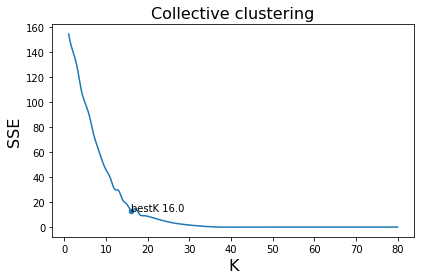

Para el Mccg  10
2018-09-03 20:47:45.146804: processing 1
2018-09-03 20:47:45.167166: processing 2
2018-09-03 20:47:45.181765: processing 3
2018-09-03 20:47:45.200413: processing 4
2018-09-03 20:47:45.218749: processing 5
2018-09-03 20:47:45.239346: processing 6
2018-09-03 20:47:45.262078: processing 7
2018-09-03 20:47:45.298327: processing 8
2018-09-03 20:47:45.328902: processing 9
2018-09-03 20:47:45.362765: processing 10
2018-09-03 20:47:45.397691: processing 11
2018-09-03 20:47:45.450118: processing 12
2018-09-03 20:47:45.486992: processing 13
2018-09-03 20:47:45.525447: processing 14
2018-09-03 20:47:45.566937: processing 15
2018-09-03 20:47:45.612499: processing 16
2018-09-03 20:47:45.659313: processing 17
2018-09-03 20:47:45.723909: processing 18
2018-09-03 20:47:45.791301: processing 19
2018-09-03 20:47:45.844209: processing 20
2018-09-03 20:47:45.896198: processing 21
2018-09-03 20:47:45.969034: processing 22
2018-09-03 20:47:46.027647: processing 23
2018-09-03 20:47:46.086788

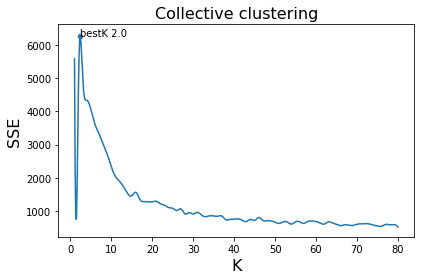

Para el Mccg  11
2018-09-03 20:47:54.961589: processing 1
2018-09-03 20:47:55.010386: processing 2
2018-09-03 20:47:55.063003: processing 3
2018-09-03 20:47:55.123162: processing 4
2018-09-03 20:47:55.191529: processing 5
2018-09-03 20:47:55.311568: processing 6
2018-09-03 20:47:55.390891: processing 7
2018-09-03 20:47:55.510479: processing 8
2018-09-03 20:47:55.725088: processing 9
2018-09-03 20:47:55.910985: processing 10
2018-09-03 20:47:56.064914: processing 11
2018-09-03 20:47:56.159235: processing 12
2018-09-03 20:47:56.258645: processing 13
2018-09-03 20:47:56.361808: processing 14
2018-09-03 20:47:56.467237: processing 15
2018-09-03 20:47:56.575474: processing 16
2018-09-03 20:47:56.685161: processing 17
2018-09-03 20:47:56.799345: processing 18
2018-09-03 20:47:56.972154: processing 19
2018-09-03 20:47:57.153210: processing 20
2018-09-03 20:47:57.433448: processing 21
2018-09-03 20:47:57.582760: processing 22
2018-09-03 20:47:57.748455: processing 23
2018-09-03 20:47:58.095535

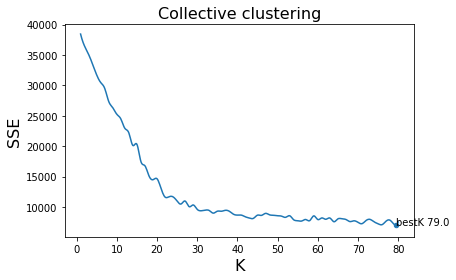

Para el Mccg  12
2018-09-03 20:48:15.448417: processing 1
2018-09-03 20:48:15.455868: processing 2
2018-09-03 20:48:15.465456: processing 3
2018-09-03 20:48:15.481296: processing 4
2018-09-03 20:48:15.505115: processing 5
2018-09-03 20:48:15.527991: processing 6
2018-09-03 20:48:15.554397: processing 7
2018-09-03 20:48:15.584288: processing 8
2018-09-03 20:48:15.615436: processing 9
2018-09-03 20:48:15.649590: processing 10
2018-09-03 20:48:15.686175: processing 11
2018-09-03 20:48:15.725856: processing 12
2018-09-03 20:48:15.768734: processing 13
2018-09-03 20:48:15.813474: processing 14
2018-09-03 20:48:15.860659: processing 15
2018-09-03 20:48:15.909794: processing 16
2018-09-03 20:48:15.966432: processing 17
2018-09-03 20:48:16.020279: processing 18
2018-09-03 20:48:16.076714: processing 19
2018-09-03 20:48:16.132552: processing 20
2018-09-03 20:48:16.192102: processing 21
2018-09-03 20:48:16.253943: processing 22
2018-09-03 20:48:16.319243: processing 23
2018-09-03 20:48:16.407326

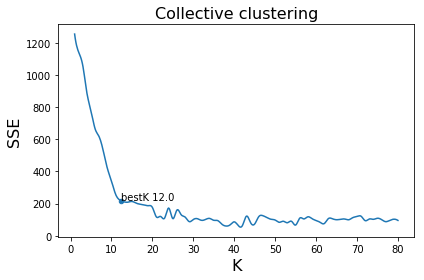

Para el Mccg  13
2018-09-03 20:48:24.863280: processing 1
2018-09-03 20:48:24.875862: processing 2
2018-09-03 20:48:24.903440: processing 3
2018-09-03 20:48:24.935382: processing 4
2018-09-03 20:48:24.956167: processing 5
2018-09-03 20:48:24.979299: processing 6
2018-09-03 20:48:25.008444: processing 7
2018-09-03 20:48:25.037154: processing 8
2018-09-03 20:48:25.082411: processing 9
2018-09-03 20:48:25.117054: processing 10
2018-09-03 20:48:25.184919: processing 11
2018-09-03 20:48:25.236836: processing 12
2018-09-03 20:48:25.289671: processing 13
2018-09-03 20:48:25.352485: processing 14
2018-09-03 20:48:25.414766: processing 15
2018-09-03 20:48:25.507798: processing 16
2018-09-03 20:48:25.574873: processing 17
2018-09-03 20:48:25.644182: processing 18
2018-09-03 20:48:25.714881: processing 19
2018-09-03 20:48:25.788578: processing 20
2018-09-03 20:48:25.865084: processing 21
2018-09-03 20:48:25.982524: processing 22
2018-09-03 20:48:26.070312: processing 23
2018-09-03 20:48:26.181874

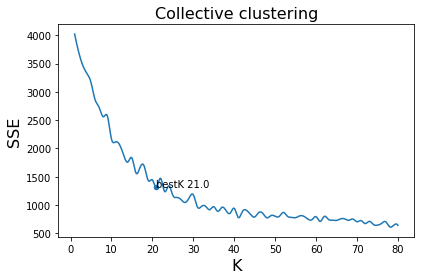

Para el Mccg  14
2018-09-03 20:48:35.373338: processing 1
2018-09-03 20:48:35.380417: processing 2
2018-09-03 20:48:35.389588: processing 3
2018-09-03 20:48:35.401596: processing 4
1


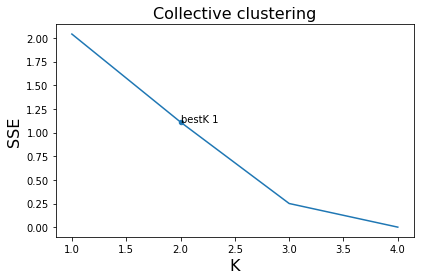

Para el Mccg  15
2018-09-03 20:48:35.834057: processing 1
2018-09-03 20:48:35.893666: processing 2
2018-09-03 20:48:35.955965: processing 3
2018-09-03 20:48:36.028491: processing 4
2018-09-03 20:48:36.124379: processing 5
2018-09-03 20:48:36.234603: processing 6
2018-09-03 20:48:36.349567: processing 7
2018-09-03 20:48:36.468039: processing 8
2018-09-03 20:48:36.684301: processing 9
2018-09-03 20:48:36.812684: processing 10
2018-09-03 20:48:36.920032: processing 11
2018-09-03 20:48:37.029574: processing 12
2018-09-03 20:48:37.163605: processing 13
2018-09-03 20:48:37.502534: processing 14
2018-09-03 20:48:37.625005: processing 15
2018-09-03 20:48:37.856221: processing 16
2018-09-03 20:48:38.238408: processing 17
2018-09-03 20:48:38.370755: processing 18
2018-09-03 20:48:38.657874: processing 19
2018-09-03 20:48:38.948262: processing 20
2018-09-03 20:48:39.247321: processing 21
2018-09-03 20:48:39.557771: processing 22
2018-09-03 20:48:39.738932: processing 23
2018-09-03 20:48:39.890946

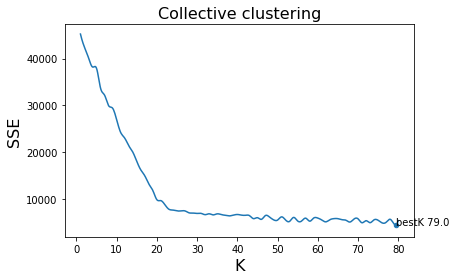

Para el Mccg  16
2018-09-03 20:49:01.197118: processing 1
2018-09-03 20:49:01.210519: processing 2
2018-09-03 20:49:01.226540: processing 3
2018-09-03 20:49:01.245200: processing 4
2018-09-03 20:49:01.270637: processing 5
2018-09-03 20:49:01.295598: processing 6
2018-09-03 20:49:01.327590: processing 7
2018-09-03 20:49:01.379233: processing 8
2018-09-03 20:49:01.413708: processing 9
2018-09-03 20:49:01.454753: processing 10
2018-09-03 20:49:01.528331: processing 11
2018-09-03 20:49:01.569715: processing 12
2018-09-03 20:49:01.642110: processing 13
2018-09-03 20:49:01.717908: processing 14
2018-09-03 20:49:01.810565: processing 15
2018-09-03 20:49:01.869272: processing 16
2018-09-03 20:49:01.956348: processing 17
2018-09-03 20:49:02.020480: processing 18
2018-09-03 20:49:02.085210: processing 19
2018-09-03 20:49:02.180731: processing 20
2018-09-03 20:49:02.245190: processing 21
2018-09-03 20:49:02.318071: processing 22
2018-09-03 20:49:02.390360: processing 23
2018-09-03 20:49:02.464575

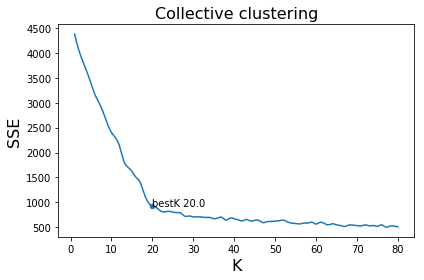

Para el Mccg  17
2018-09-03 20:49:10.871562: processing 1
2018-09-03 20:49:10.886498: processing 2
2018-09-03 20:49:10.918846: processing 3
2018-09-03 20:49:10.943374: processing 4
2018-09-03 20:49:10.984905: processing 5
2018-09-03 20:49:11.012304: processing 6
2018-09-03 20:49:11.039527: processing 7
2018-09-03 20:49:11.092358: processing 8
2018-09-03 20:49:11.130048: processing 9
2018-09-03 20:49:11.166813: processing 10
2018-09-03 20:49:11.202343: processing 11
2018-09-03 20:49:11.242043: processing 12
2018-09-03 20:49:11.291957: processing 13
2018-09-03 20:49:11.368348: processing 14
2018-09-03 20:49:11.464163: processing 15
2018-09-03 20:49:11.512350: processing 16
2018-09-03 20:49:11.597660: processing 17
2018-09-03 20:49:11.647901: processing 18
2018-09-03 20:49:11.701595: processing 19
2018-09-03 20:49:11.796521: processing 20
2018-09-03 20:49:11.862769: processing 21
2018-09-03 20:49:11.924202: processing 22
2018-09-03 20:49:12.025685: processing 23
2018-09-03 20:49:12.090169

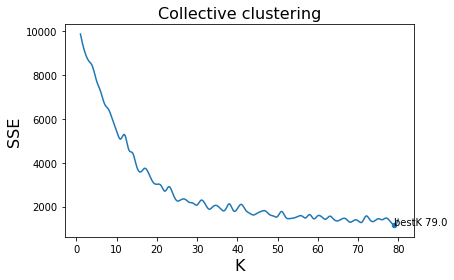

Para el Mccg  18
2018-09-03 20:49:21.031581: processing 1
2018-09-03 20:49:21.090700: processing 2
2018-09-03 20:49:21.153155: processing 3
2018-09-03 20:49:21.221684: processing 4
2018-09-03 20:49:21.295330: processing 5
2018-09-03 20:49:21.367504: processing 6
2018-09-03 20:49:21.445742: processing 7
2018-09-03 20:49:21.524133: processing 8
2018-09-03 20:49:21.603755: processing 9
2018-09-03 20:49:21.765719: processing 10
2018-09-03 20:49:21.850092: processing 11
2018-09-03 20:49:21.936052: processing 12
2018-09-03 20:49:22.028045: processing 13
2018-09-03 20:49:22.121797: processing 14
2018-09-03 20:49:22.217948: processing 15
2018-09-03 20:49:22.320401: processing 16
2018-09-03 20:49:22.594471: processing 17
2018-09-03 20:49:22.697376: processing 18
2018-09-03 20:49:22.806205: processing 19
2018-09-03 20:49:23.076171: processing 20
2018-09-03 20:49:23.188593: processing 21
2018-09-03 20:49:23.306154: processing 22
2018-09-03 20:49:23.421894: processing 23
2018-09-03 20:49:23.541024

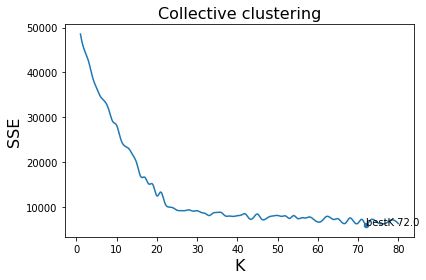

Para el Mccg  19
2018-09-03 20:49:42.683134: processing 1
2018-09-03 20:49:42.700933: processing 2
2018-09-03 20:49:42.720759: processing 3
2018-09-03 20:49:42.742566: processing 4
2018-09-03 20:49:42.768290: processing 5
2018-09-03 20:49:42.795149: processing 6
2018-09-03 20:49:42.824779: processing 7
2018-09-03 20:49:42.857810: processing 8
2018-09-03 20:49:42.896696: processing 9
2018-09-03 20:49:42.932179: processing 10
2018-09-03 20:49:42.970057: processing 11
2018-09-03 20:49:43.009538: processing 12
2018-09-03 20:49:43.058314: processing 13
2018-09-03 20:49:43.102462: processing 14
2018-09-03 20:49:43.150751: processing 15
2018-09-03 20:49:43.200003: processing 16
2018-09-03 20:49:43.250836: processing 17
2018-09-03 20:49:43.303826: processing 18
2018-09-03 20:49:43.358318: processing 19
2018-09-03 20:49:43.460109: processing 20
2018-09-03 20:49:43.532301: processing 21
2018-09-03 20:49:43.599830: processing 22
2018-09-03 20:49:43.664194: processing 23
2018-09-03 20:49:43.730454

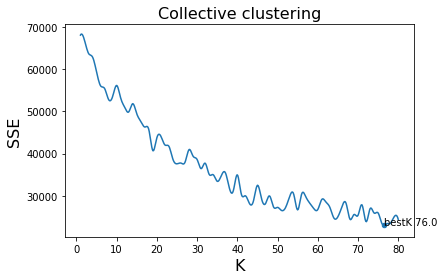

Para el Mccg  21
2018-09-03 20:49:52.438672: processing 1
2018-09-03 20:49:52.447090: processing 2
2018-09-03 20:49:52.455967: processing 3
2018-09-03 20:49:52.468547: processing 4
2018-09-03 20:49:52.485492: processing 5
2018-09-03 20:49:52.501380: processing 6
2018-09-03 20:49:52.521374: processing 7
2018-09-03 20:49:52.542236: processing 8
2018-09-03 20:49:52.565881: processing 9
2018-09-03 20:49:52.594567: processing 10
2018-09-03 20:49:52.620535: processing 11
2018-09-03 20:49:52.651668: processing 12
2018-09-03 20:49:52.682109: processing 13
2018-09-03 20:49:52.715776: processing 14
2018-09-03 20:49:52.760938: processing 15
2018-09-03 20:49:52.798085: processing 16
2018-09-03 20:49:52.836543: processing 17
2018-09-03 20:49:52.878063: processing 18
2018-09-03 20:49:52.931141: processing 19
2018-09-03 20:49:52.985190: processing 20
2018-09-03 20:49:53.041118: processing 21
2018-09-03 20:49:53.100033: processing 22
2018-09-03 20:49:53.151698: processing 23
2018-09-03 20:49:53.212693

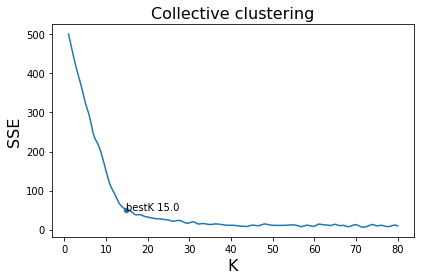

Para el Mccg  22
2018-09-03 20:50:00.741902: processing 1
2018-09-03 20:50:00.946293: processing 2
2018-09-03 20:50:01.161761: processing 3
2018-09-03 20:50:01.356140: processing 4
2018-09-03 20:50:01.555274: processing 5
2018-09-03 20:50:01.757835: processing 6
2018-09-03 20:50:01.964930: processing 7
2018-09-03 20:50:02.175934: processing 8
2018-09-03 20:50:02.388601: processing 9
2018-09-03 20:50:02.654067: processing 10
2018-09-03 20:50:02.935544: processing 11
2018-09-03 20:50:03.163071: processing 12
2018-09-03 20:50:03.405158: processing 13
2018-09-03 20:50:03.649910: processing 14
2018-09-03 20:50:03.932126: processing 15
2018-09-03 20:50:04.219972: processing 16
2018-09-03 20:50:04.472502: processing 17
2018-09-03 20:50:04.730316: processing 18
2018-09-03 20:50:04.990567: processing 19
2018-09-03 20:50:05.254467: processing 20
2018-09-03 20:50:05.524501: processing 21
2018-09-03 20:50:05.792908: processing 22
2018-09-03 20:50:06.059732: processing 23
2018-09-03 20:50:06.331305

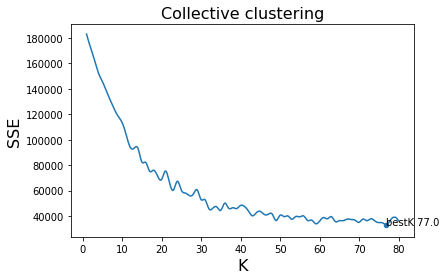

Para el Mccg  23
2018-09-03 20:50:29.051259: processing 1
2018-09-03 20:50:29.104886: processing 2
2018-09-03 20:50:29.155110: processing 3
2018-09-03 20:50:29.207051: processing 4
2018-09-03 20:50:29.263643: processing 5
2018-09-03 20:50:29.322549: processing 6
2018-09-03 20:50:29.383539: processing 7
2018-09-03 20:50:29.446300: processing 8
2018-09-03 20:50:29.561872: processing 9
2018-09-03 20:50:29.632368: processing 10
2018-09-03 20:50:29.702766: processing 11
2018-09-03 20:50:29.776021: processing 12
2018-09-03 20:50:29.852884: processing 13
2018-09-03 20:50:29.991992: processing 14
2018-09-03 20:50:30.145236: processing 15
2018-09-03 20:50:30.232574: processing 16
2018-09-03 20:50:30.320373: processing 17
2018-09-03 20:50:30.412056: processing 18
2018-09-03 20:50:30.507567: processing 19
2018-09-03 20:50:30.603711: processing 20
2018-09-03 20:50:30.701471: processing 21
2018-09-03 20:50:30.802238: processing 22
2018-09-03 20:50:30.904869: processing 23
2018-09-03 20:50:31.287067

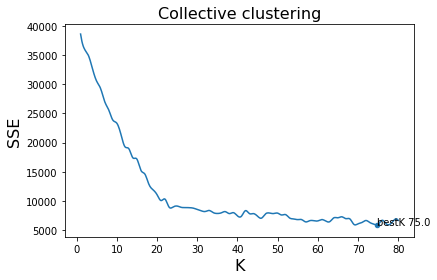

Para el Mccg  25
2018-09-03 20:50:45.684464: processing 1
2018-09-03 20:50:45.696809: processing 2
2018-09-03 20:50:45.710721: processing 3
2018-09-03 20:50:45.726390: processing 4
2018-09-03 20:50:45.745431: processing 5
2018-09-03 20:50:45.766381: processing 6
2018-09-03 20:50:45.789574: processing 7
2018-09-03 20:50:45.834064: processing 8
2018-09-03 20:50:45.867721: processing 9
2018-09-03 20:50:45.898193: processing 10
2018-09-03 20:50:45.929925: processing 11
2018-09-03 20:50:45.963371: processing 12
2018-09-03 20:50:46.024976: processing 13
2018-09-03 20:50:46.091903: processing 14
2018-09-03 20:50:46.150971: processing 15
2018-09-03 20:50:46.192882: processing 16
2018-09-03 20:50:46.237417: processing 17
2018-09-03 20:50:46.302763: processing 18
2018-09-03 20:50:46.371763: processing 19
2018-09-03 20:50:46.442929: processing 20
2018-09-03 20:50:46.516289: processing 21
2018-09-03 20:50:46.572457: processing 22
2018-09-03 20:50:46.649429: processing 23
2018-09-03 20:50:46.712962

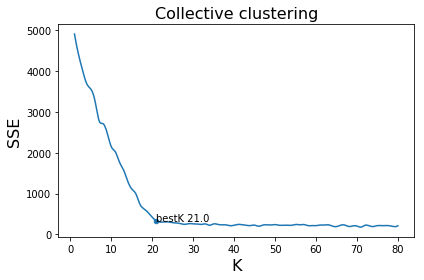

Para el Mccg  26
2018-09-03 20:50:53.853876: processing 1
2018-09-03 20:50:53.859714: processing 2
2018-09-03 20:50:53.866368: processing 3
1


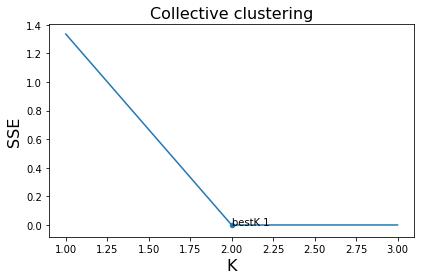

Para el Mccg  27
2018-09-03 20:50:54.008247: processing 1
2018-09-03 20:50:54.019183: processing 2
2018-09-03 20:50:54.032550: processing 3
2018-09-03 20:50:54.047608: processing 4
2018-09-03 20:50:54.066513: processing 5
2018-09-03 20:50:54.087370: processing 6
2018-09-03 20:50:54.111940: processing 7
2018-09-03 20:50:54.139300: processing 8
2018-09-03 20:50:54.174245: processing 9
2018-09-03 20:50:54.206238: processing 10
2018-09-03 20:50:54.237308: processing 11
2018-09-03 20:50:54.272180: processing 12
2018-09-03 20:50:54.309749: processing 13
2018-09-03 20:50:54.348890: processing 14
2018-09-03 20:50:54.389417: processing 15
2018-09-03 20:50:54.433120: processing 16
2018-09-03 20:50:54.477793: processing 17
2018-09-03 20:50:54.524622: processing 18
2018-09-03 20:50:54.576703: processing 19
2018-09-03 20:50:54.626296: processing 20
2018-09-03 20:50:54.677820: processing 21
2018-09-03 20:50:54.776844: processing 22
2018-09-03 20:50:54.833401: processing 23
2018-09-03 20:50:54.891822

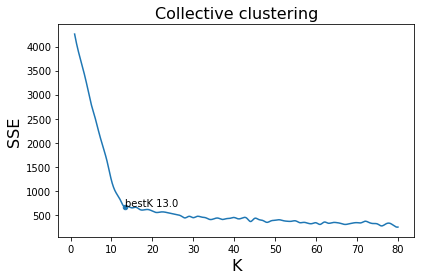

Para el Mccg  28
2018-09-03 20:51:02.432043: processing 1
2018-09-03 20:51:02.438397: processing 2
2018-09-03 20:51:02.445493: processing 3
2018-09-03 20:51:02.458357: processing 4
2018-09-03 20:51:02.468861: processing 5
2018-09-03 20:51:02.486278: processing 6
2018-09-03 20:51:02.503098: processing 7
2018-09-03 20:51:02.519173: processing 8
2018-09-03 20:51:02.537128: processing 9
2018-09-03 20:51:02.563146: processing 10
2018-09-03 20:51:02.587239: processing 11
2018-09-03 20:51:02.613481: processing 12
2018-09-03 20:51:02.640889: processing 13
2018-09-03 20:51:02.668824: processing 14
2018-09-03 20:51:02.698352: processing 15
2018-09-03 20:51:02.729108: processing 16
2018-09-03 20:51:02.767454: processing 17
2018-09-03 20:51:02.801170: processing 18
2018-09-03 20:51:02.835992: processing 19
2018-09-03 20:51:02.885694: processing 20
2018-09-03 20:51:02.927226: processing 21
2018-09-03 20:51:02.974703: processing 22
2018-09-03 20:51:03.021137: processing 23
2018-09-03 20:51:03.068331

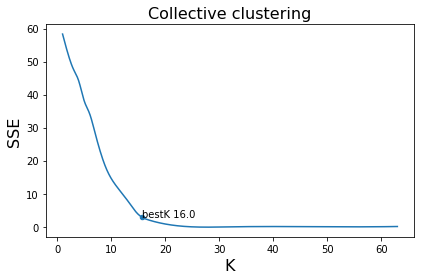

Done


In [13]:
for i in range(len(mccg)):
    path = "RESULTS/MCCG_"+str(mccg[i])
    file='./%s/mccg_%s.json' %(path,mccg[i])
    print("Para el Mccg ",mccg[i])
    
    individual_footprint="%s.individual_footprint" %(file)
    individual_clusters="%s.clusters" %(individual_footprint)
    collective_clusters="%s.collective_footprint.clusters" %(file)
    collective_labels="%s.collective_footprint.labels" %(file)
    
    f=open(individual_clusters)   #  uid,cluster_id,profile
    f.readline()                  #  Saltamos una linea

    data=[]
    for row in f:
        row=row.strip().split(';')
        uid=row[0]
        cluster_id=row[1]
        individual_profile=np.array([float(el) for el in row[2:]])
        data.append(((uid,cluster_id),individual_profile))

    to_cluster=[el[1] for el in data]
    
    if len(to_cluster) >= 80:
        tests=np.arange(1,80+1)
    else:
        tests=np.arange(1,len(to_cluster)+1)
    # tests=list(tests)+list(np.arange(50,150,5))
    K=process_footprint(to_cluster,tests,log=True)
    # K=process_footprint(to_cluster,np.arange(1,len(to_cluster)+1),log=True)

    import pickle
    # pickle.dump( K, open( "%s.models.p" %(file), "wb" ) )
    
    # Choose K for global clustering 
    %matplotlib inline
    x=sorted(K.keys())
    y=[K[k]['inertia'] for k in x]
    best_k,pylab=compute_best_k(x,y,len(to_cluster),plot=True,points=500)

    print(best_k)
    #best_k=18 #a mano
    plt.title("Collective clustering",fontsize=16)
    plt.ylabel("SSE",fontsize=16)
    plt.xlabel("K",fontsize=16)
    plt.tight_layout()
    plt.show()
    # pylab.savefig('%s.png' %(raw_data),dpi=200)

    import pandas as pd
    df_sse=pd.DataFrame([x,y]).T
    df_sse.columns=['x','y']
    #df_sse.to_csv('%s.png.sse.csv' %(raw_data),index=False)
    
    
    # EXPORTANDO RESULTADOS
    cluster_centers_=K[best_k]['estimator'].cluster_centers_
    labels_=K[best_k]['estimator'].labels_
    fw=open(collective_clusters,"w")
    fw2=open(collective_labels,"w")
    fw.write('collective_cluster;d0t0;d1t0;d2t0;d3t0;d4t0;d5t0;d6t0;d0t1;d1t1;d2t1;d3t1;d4t1;d5t1;d6t1;d0t2;d1t2;d2t2;d3t2;d4t2;d5t2;d6t2;d0t3;d1t3;d2t3;d3t3;d4t3;d5t3;d6t3\n')
    fw2.write('customer_tag;individual_cluster;collective_cluster;d0t0;d1t0;d2t0;d3t0;d4t0;d5t0;d6t0;d0t1;d1t1;d2t1;d3t1;d4t1;d5t1;d6t1;d0t2;d1t2;d2t2;d3t2;d4t2;d5t2;d6t2;d0t3;d1t3;d2t3;d3t3;d4t3;d5t3;d6t3\n')

    #export individual centroids
    for j in np.arange(len(cluster_centers_)):
        string="%s;%s\n"%(j,';'.join([str(el) for el in cluster_centers_[j]])) #cluster_id,centroid
        fw.write(string)
    fw.flush()

    #export original data and labels
    for j in np.arange(len(data)):
        uid=data[j][0]
        profile=data[j][1]
        label=labels_[j]
        string="%s;%s;%s;%s\n" %(uid[0],uid[1],label
                                    ,';'.join([str(el) for el in profile]))#uid,individual_cluster_id,collective_cluster_id,profile
        fw2.write(string)
    fw2.flush()

print('Done')

# RESULTADOS

## Unimos los resultados por cada mccg

In [14]:
for i in range(len(mccg)):
#for i in range(1):
    path = "RESULTS/MCCG_"+str(mccg[i])
    file='./%s/mccg_%s.json' %(path,mccg[i])
    print("Para el Mccg",mccg[i])
    
    footprint="%s.individual_footprint" %(file)
    individual_clusters="%s.individual_footprint.clusters" %(file)
    individual_labels="%s.individual_footprint.labels" %(file)
    collective_clusters="%s.collective_footprint.clusters" %(file)
    collective_labels="%s.collective_footprint.labels" %(file)
    
    # Unimos
    footprint = pd.read_csv(footprint, sep=",", header=0)
    footprint.rename(columns={'customer_id':'customer_tag'}, inplace=True)     
    individual_labels = pd.read_csv(individual_labels, sep=";", header=0, index_col=False)
    collective_labels = pd.read_csv(collective_labels, sep=";", header=0, index_col=False)

    result = pd.merge(individual_labels, collective_labels, on=['customer_tag', 'individual_cluster'])
    result = result.iloc[:, :-28]
    result= pd.merge(footprint, result, on=['customer_tag','year', 'week'])
    result1 = result.iloc[:, :-29]
    result = pd.concat([result1, result[['collective_cluster']]], axis=1)
    result[['year','week','profile_id','size','individual_cluster','collective_cluster']] = result[['year','week','profile_id','size','individual_cluster','collective_cluster']].astype(int)

    path_res='./%s/mccg_%s_results.csv.json' %(path,mccg[i])
    result.to_csv(path_res,index=False)
print('Done')

Para el Mccg 2
Para el Mccg 3
Para el Mccg 4
Para el Mccg 5
Para el Mccg 6
Para el Mccg 8
Para el Mccg 9
Para el Mccg 10
Para el Mccg 11
Para el Mccg 12
Para el Mccg 13
Para el Mccg 14
Para el Mccg 15
Para el Mccg 16
Para el Mccg 17
Para el Mccg 18
Para el Mccg 19
Para el Mccg 21
Para el Mccg 22
Para el Mccg 23
Para el Mccg 25
Para el Mccg 26
Para el Mccg 27
Para el Mccg 28
Done


## Graficos

### Numero de Clusters por  mccg

Para el Mccg 2
=>   77  clusters


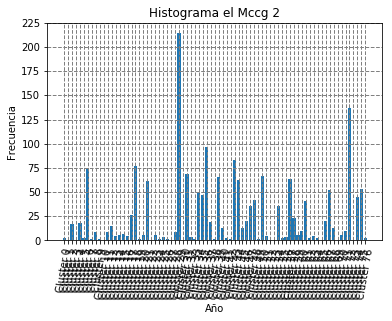

Para el Mccg 3
=>   15  clusters


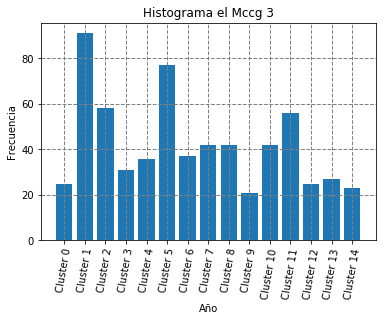

Para el Mccg 4
=>   16  clusters


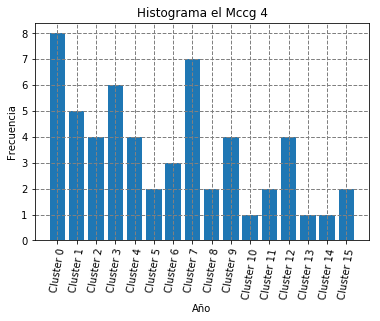

Para el Mccg 5
=>   14  clusters


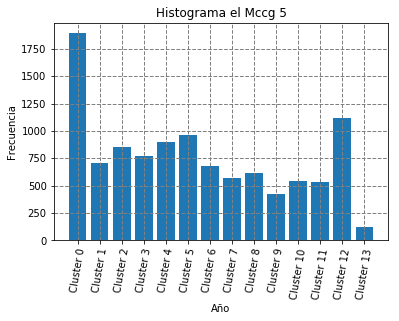

Para el Mccg 6
=>   19  clusters


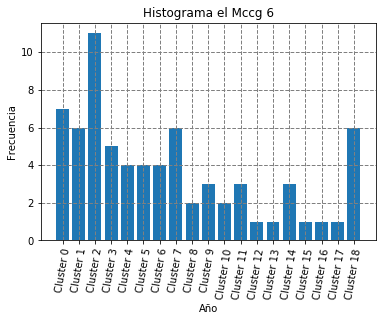

Para el Mccg 8
=>   70  clusters


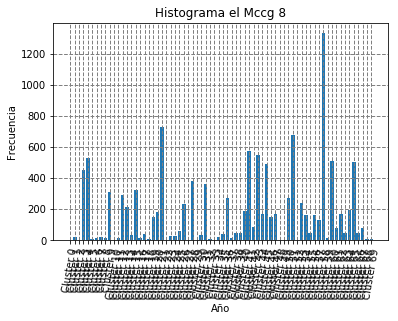

Para el Mccg 9
=>   16  clusters


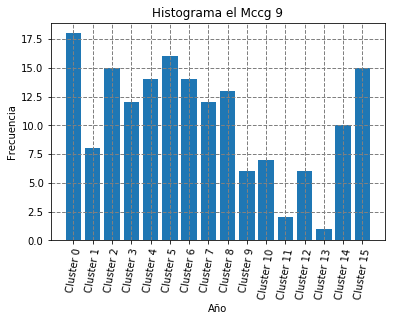

Para el Mccg 10
=>   2  clusters


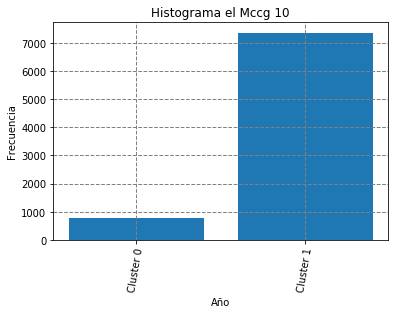

Para el Mccg 11
=>   79  clusters


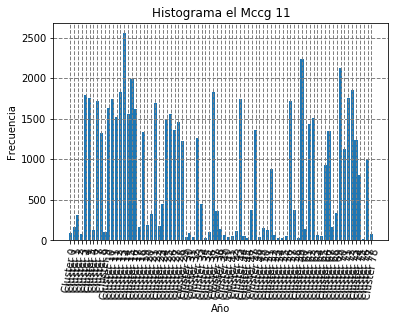

Para el Mccg 12
=>   12  clusters


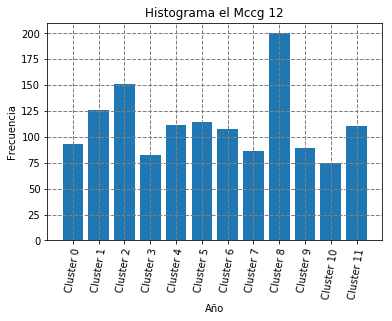

Para el Mccg 13
=>   21  clusters


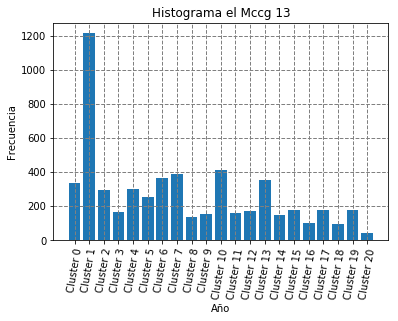

Para el Mccg 14
=>   1  clusters


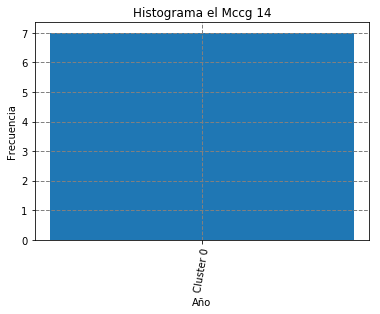

Para el Mccg 15
=>   79  clusters


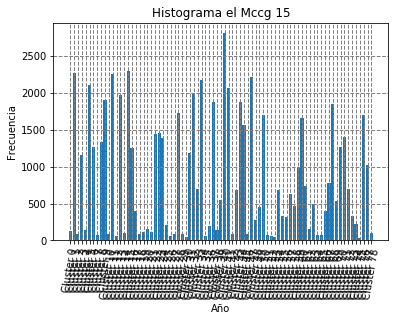

Para el Mccg 16
=>   20  clusters


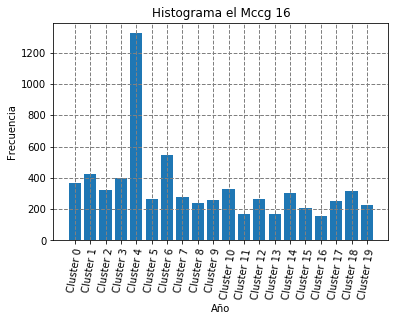

Para el Mccg 17
=>   79  clusters


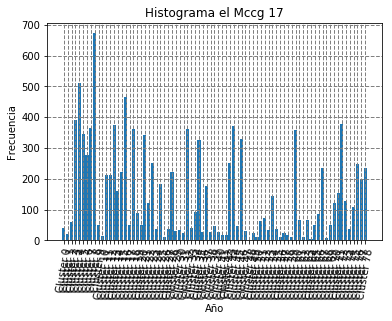

Para el Mccg 18
=>   72  clusters


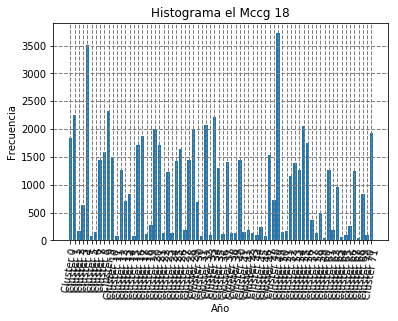

Para el Mccg 19
=>   76  clusters


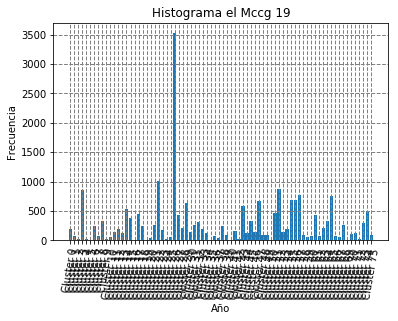

Para el Mccg 21
=>   15  clusters


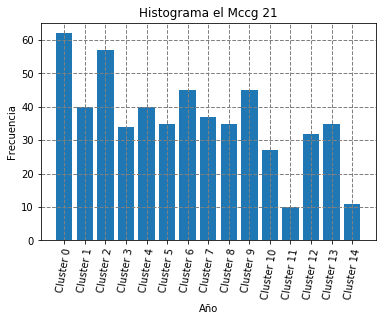

Para el Mccg 22
=>   77  clusters


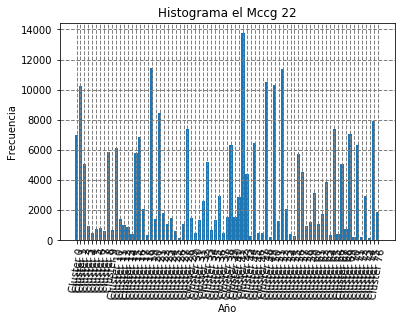

Para el Mccg 23
=>   75  clusters


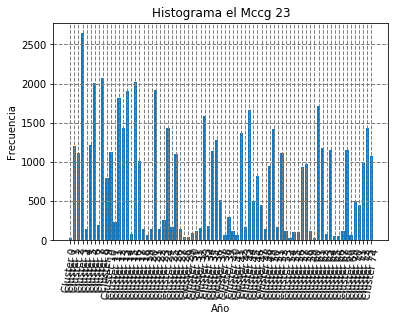

Para el Mccg 25
=>   21  clusters


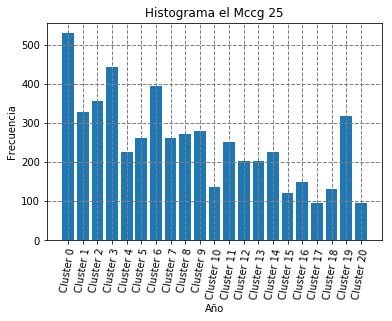

Para el Mccg 26
=>   1  clusters


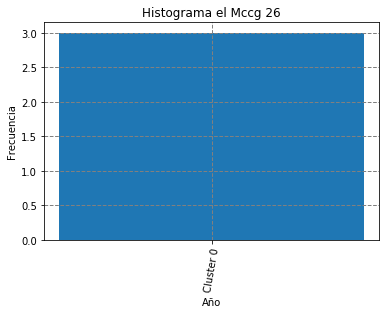

Para el Mccg 27
=>   13  clusters


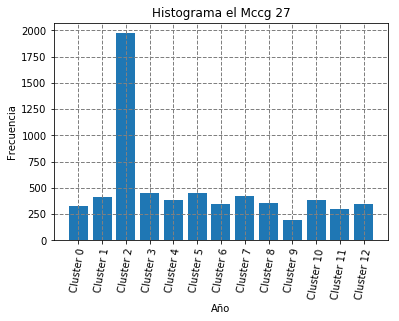

Para el Mccg 28
=>   16  clusters


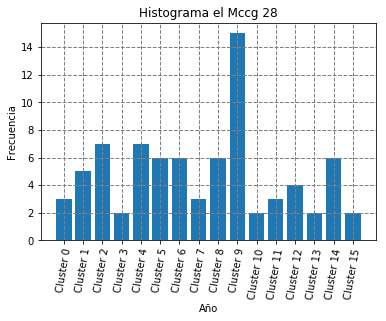

Done


In [15]:
for i in range(len(mccg)):
    print("Para el Mccg",mccg[i])
    path = "RESULTS/MCCG_"+str(mccg[i])
    path_res='./%s/mccg_%s_results.csv.json' %(path,mccg[i])
    
    result = pd.read_csv(path_res, sep=",", header=0)
    
    nn= result.groupby(['collective_cluster'], as_index=False, sort=True)['customer_tag'].count()
    print("=>  ",str(len(nn))," clusters")
    fig, ax = plt.subplots()
    ax.bar(nn.index, nn['customer_tag'], align='center')
    ax.grid(color='gray', linestyle='--', linewidth=1)

    ax.set_xlabel('Año')
    ax.set_xticks(nn.index)

    ax.set_ylabel('Frecuencia')
    tag =[]
    for j in range(len(nn)):
        temp = 'Cluster '+ str(j)+''
        tag.append(temp)

    ax.set_xticklabels(tag, rotation=80)
    
    title = "Histograma el Mccg " + str(mccg[i])
    ax.set_title(title)
    plt.show()

print('Done')

### Comportamiento de los clusters en el Tiempo

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
/home/jkn/anaconda3/lib/python3.6/site-packages/matplotlib/p

Done


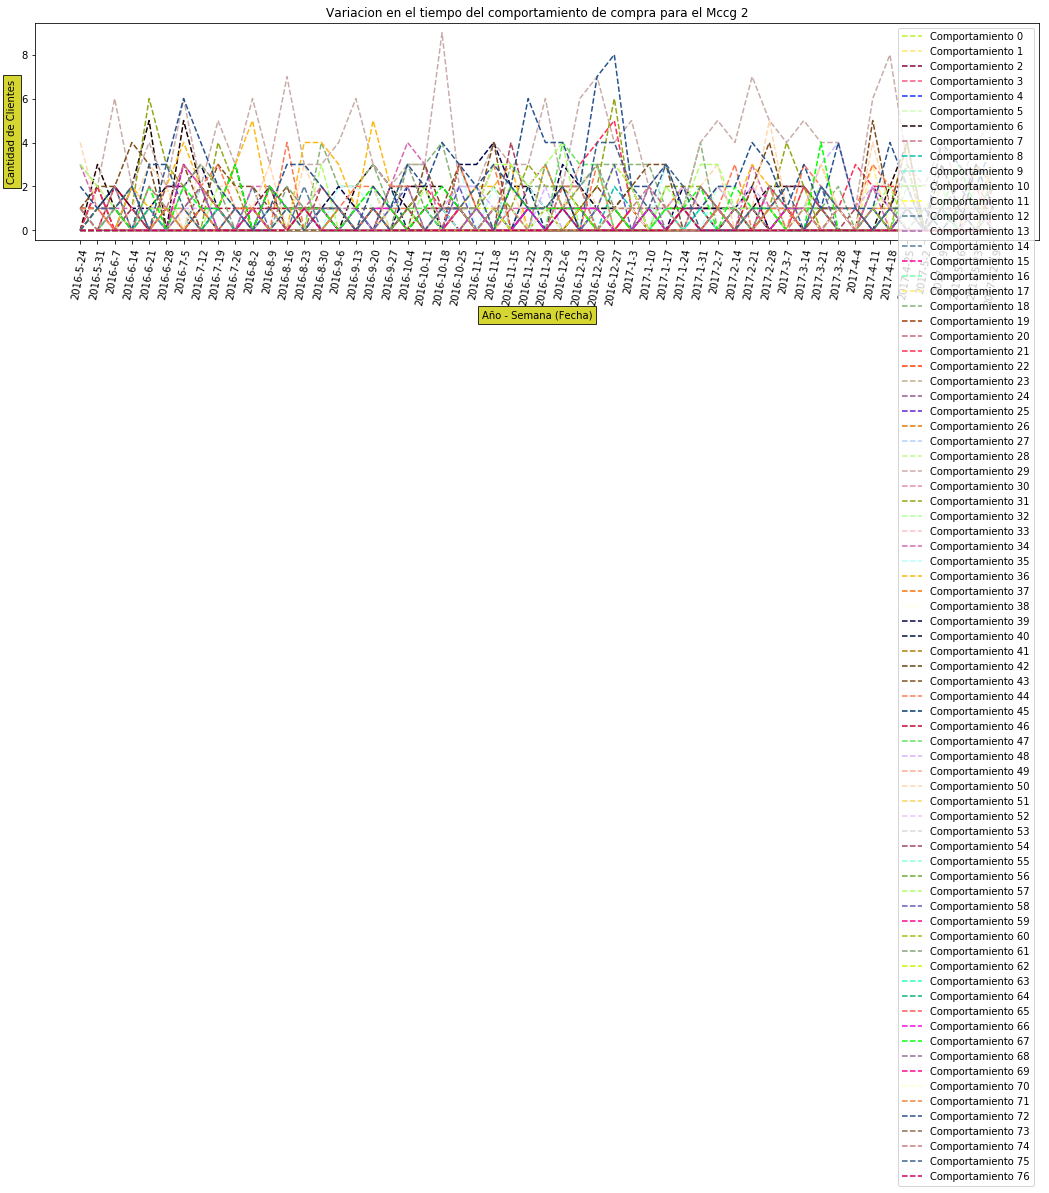

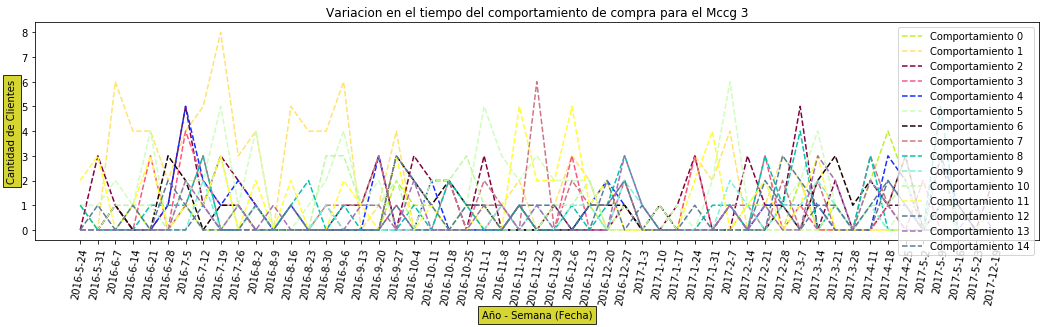

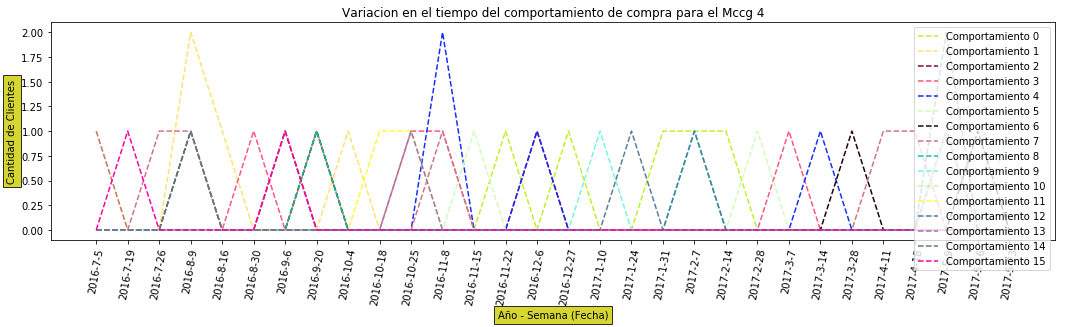

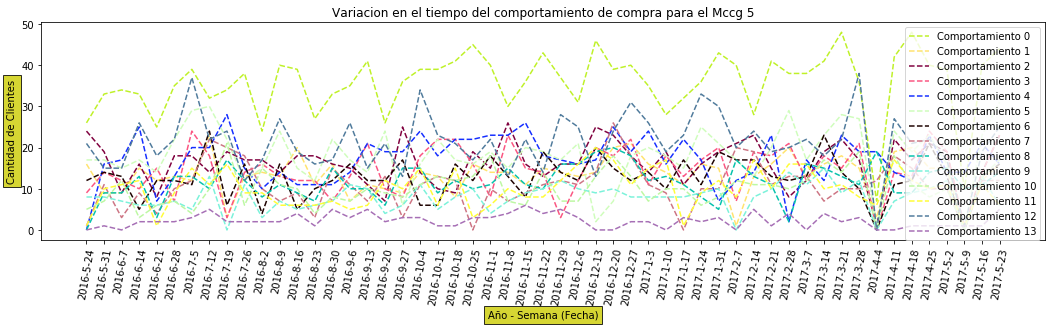

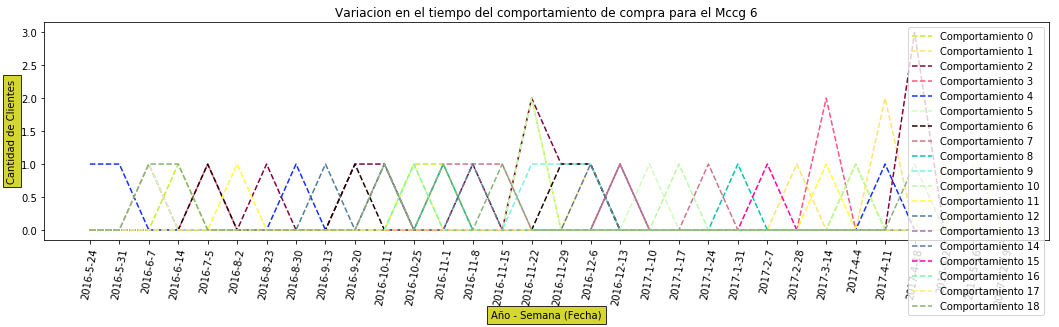

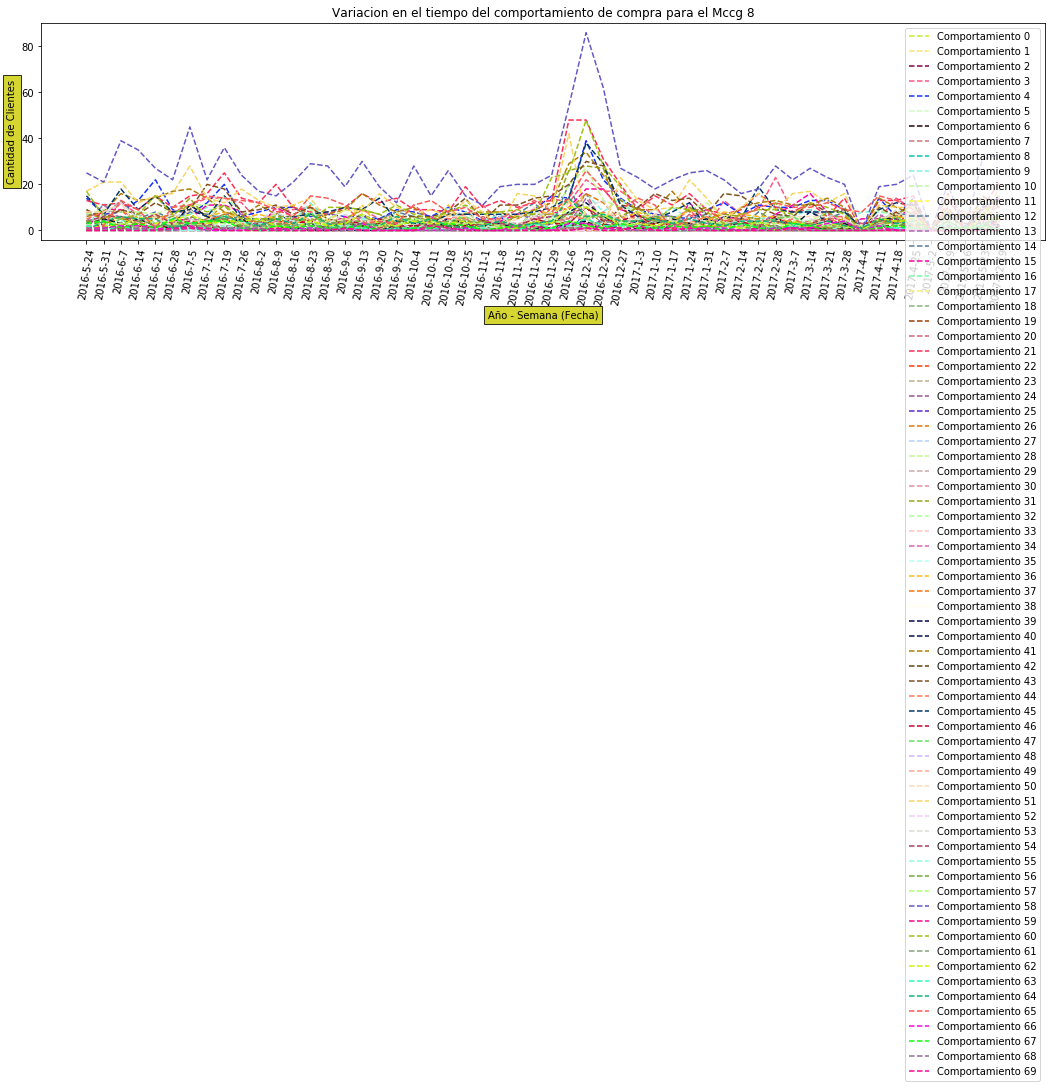

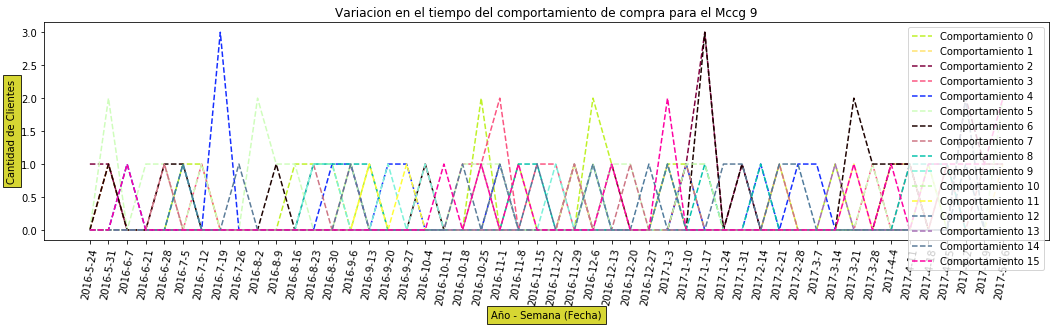

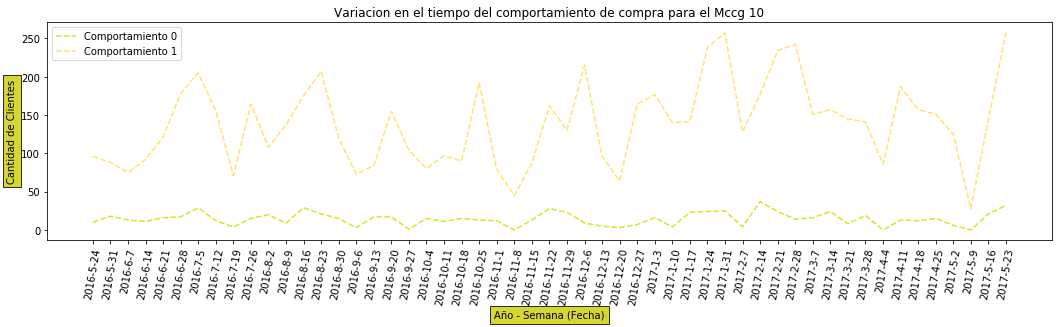

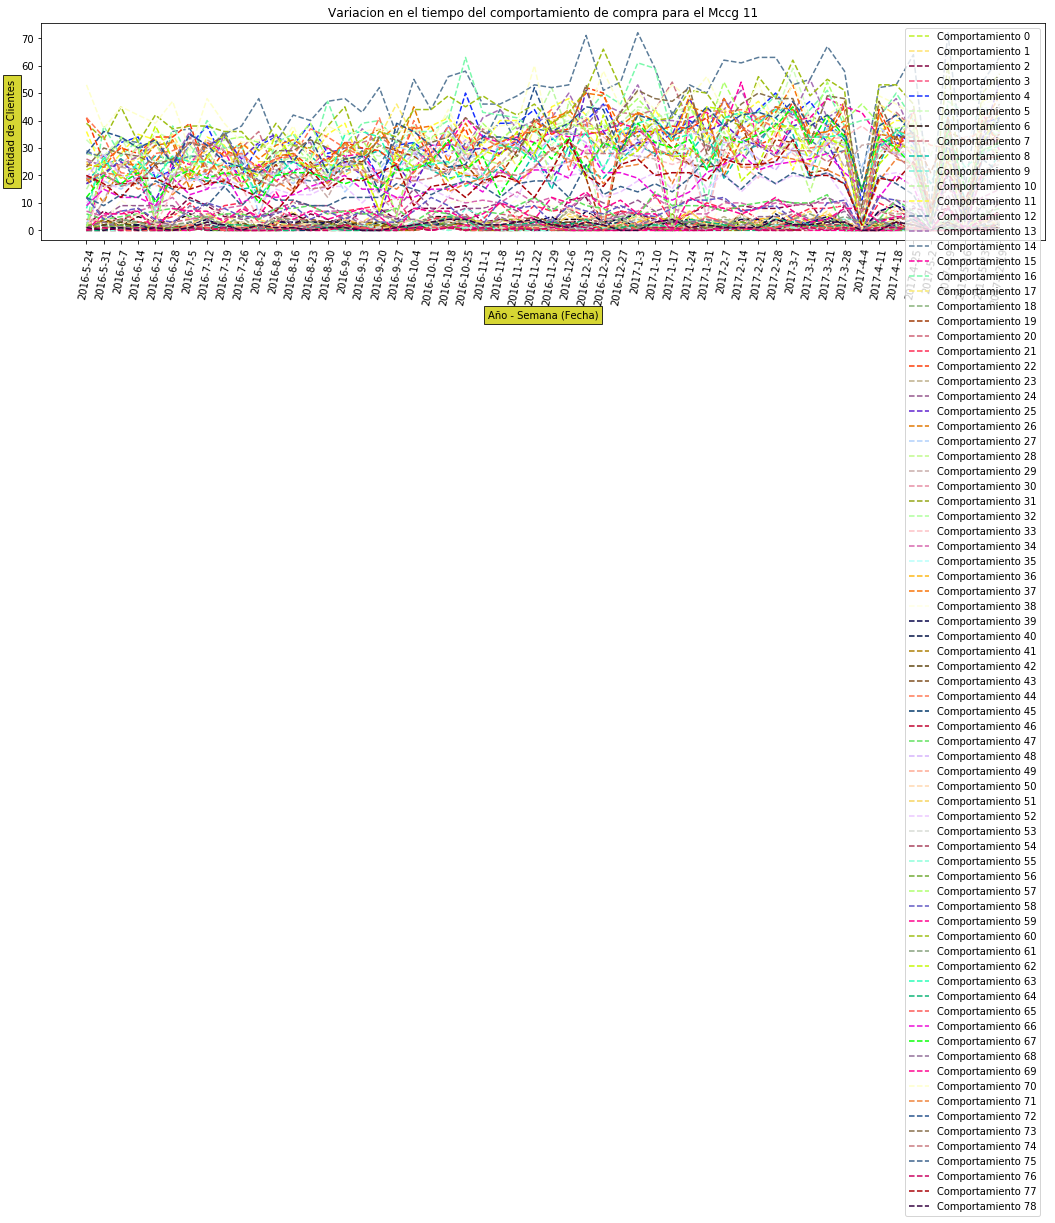

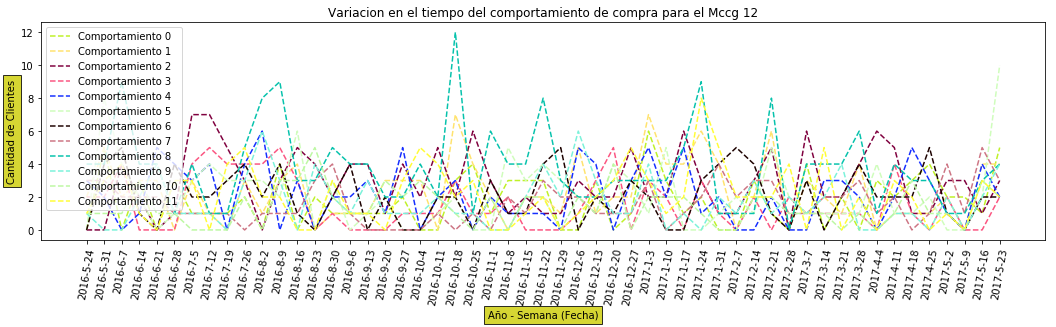

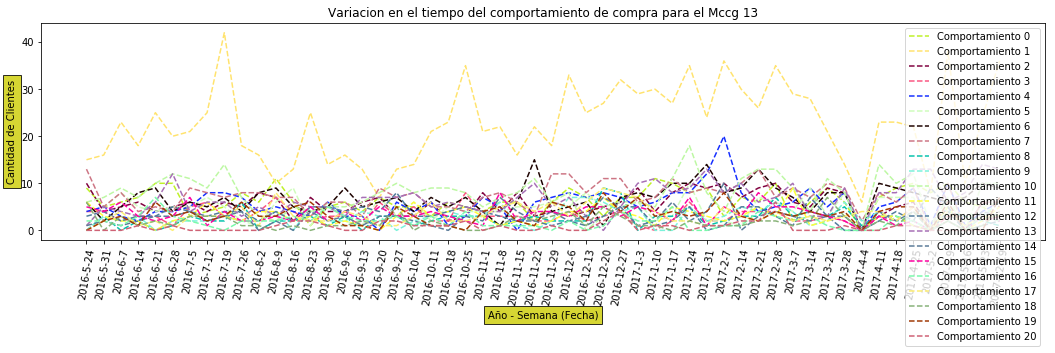

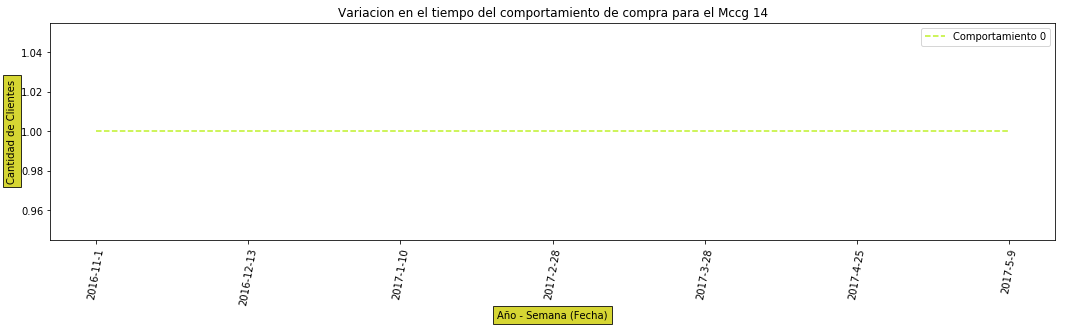

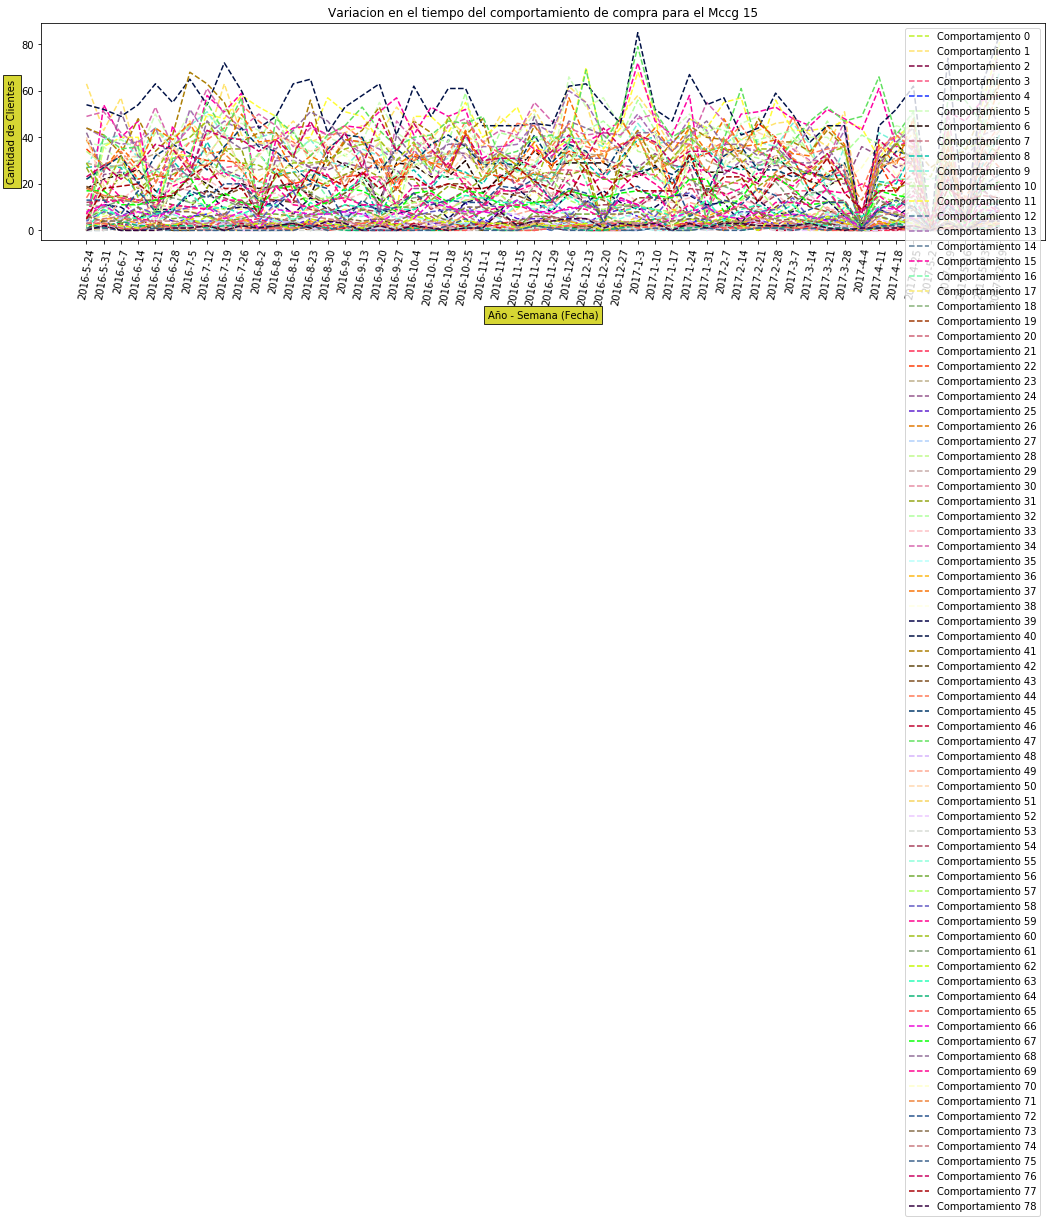

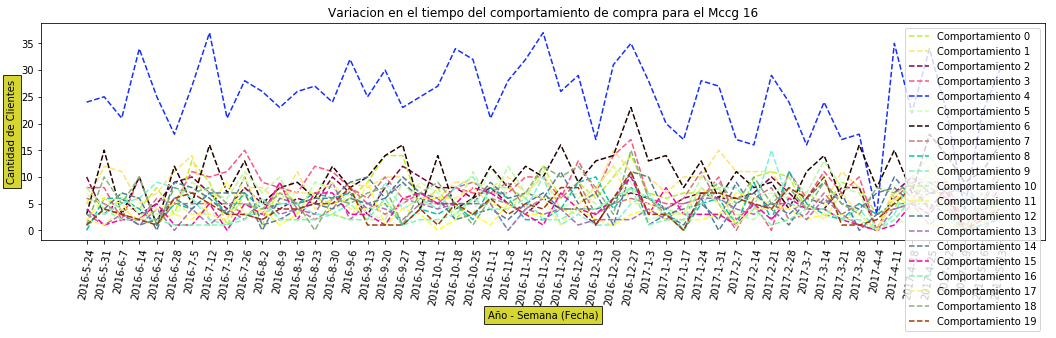

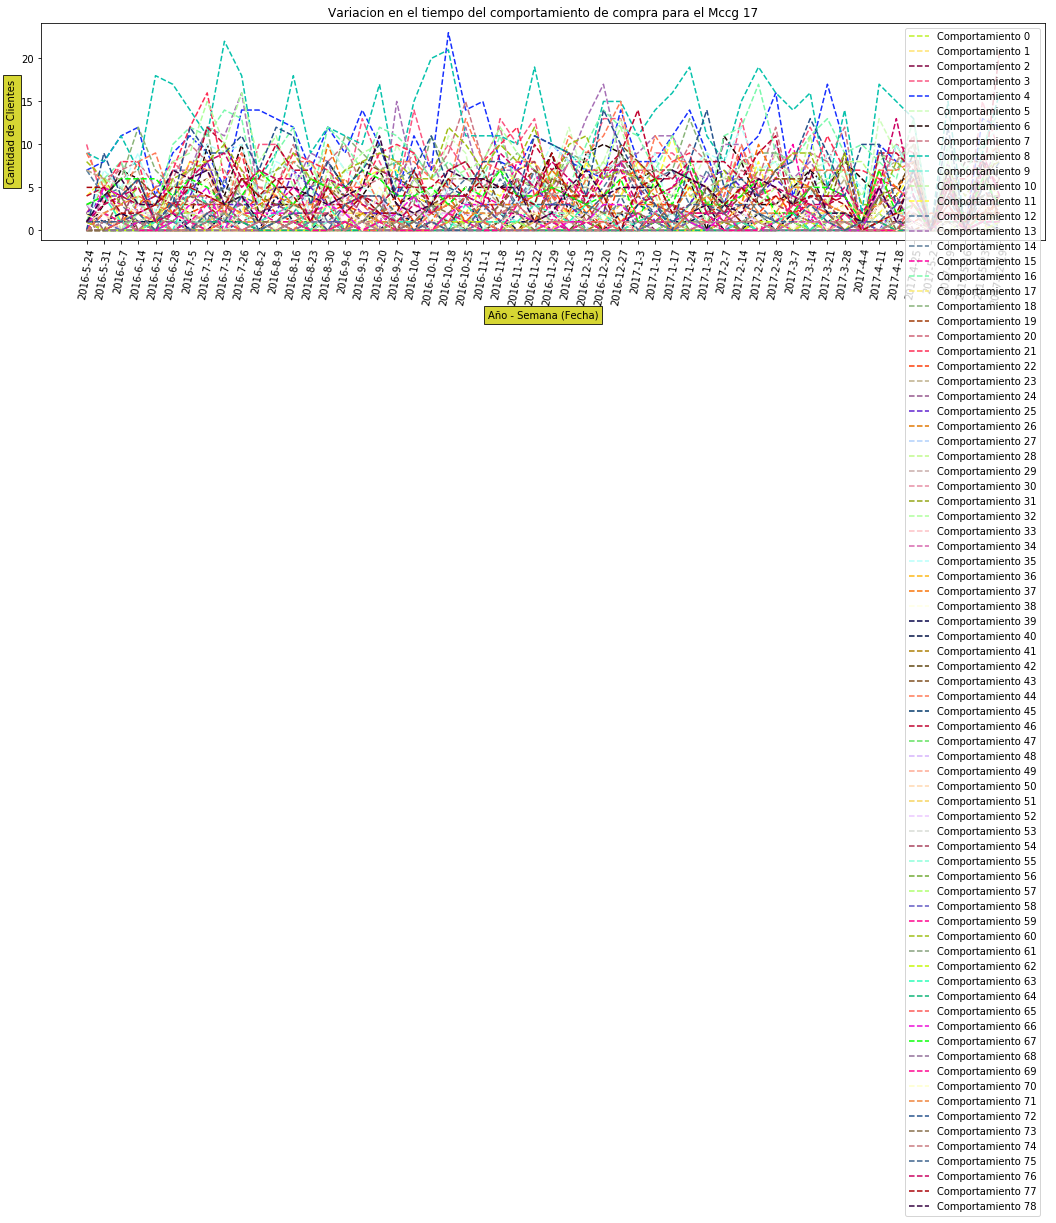

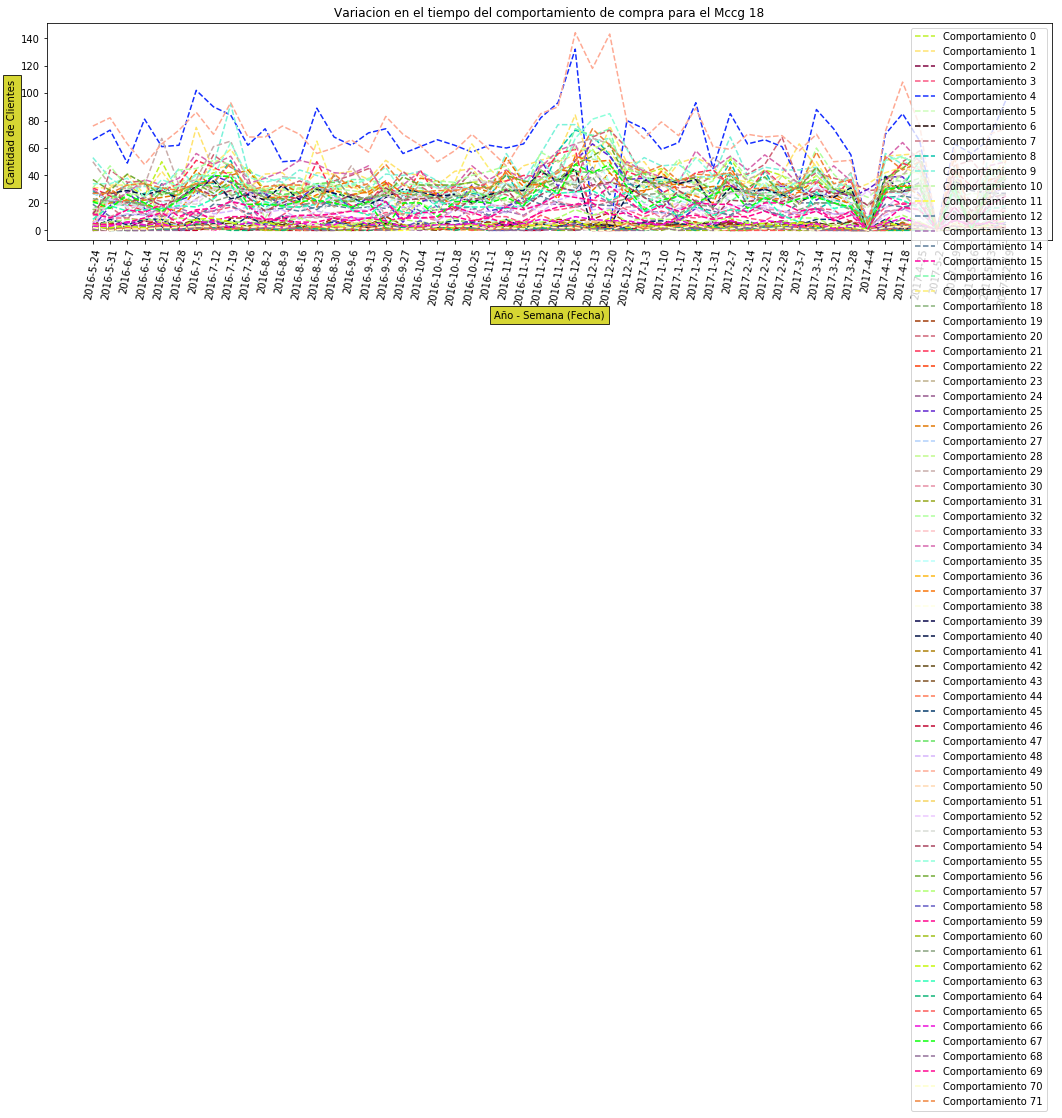

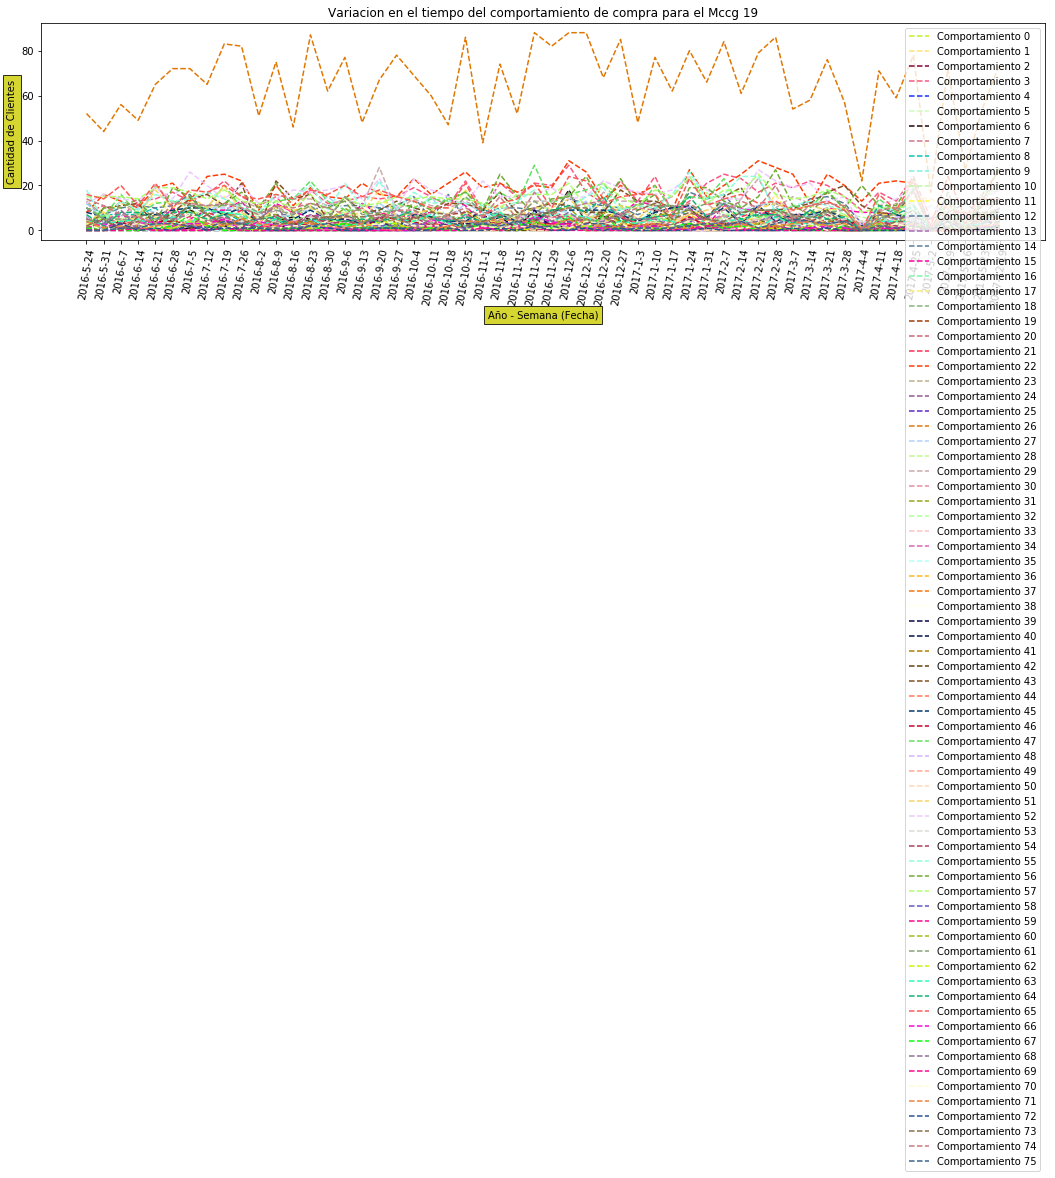

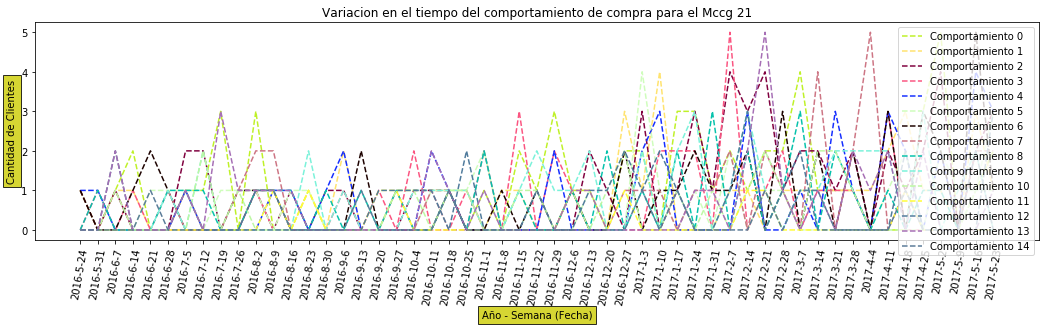

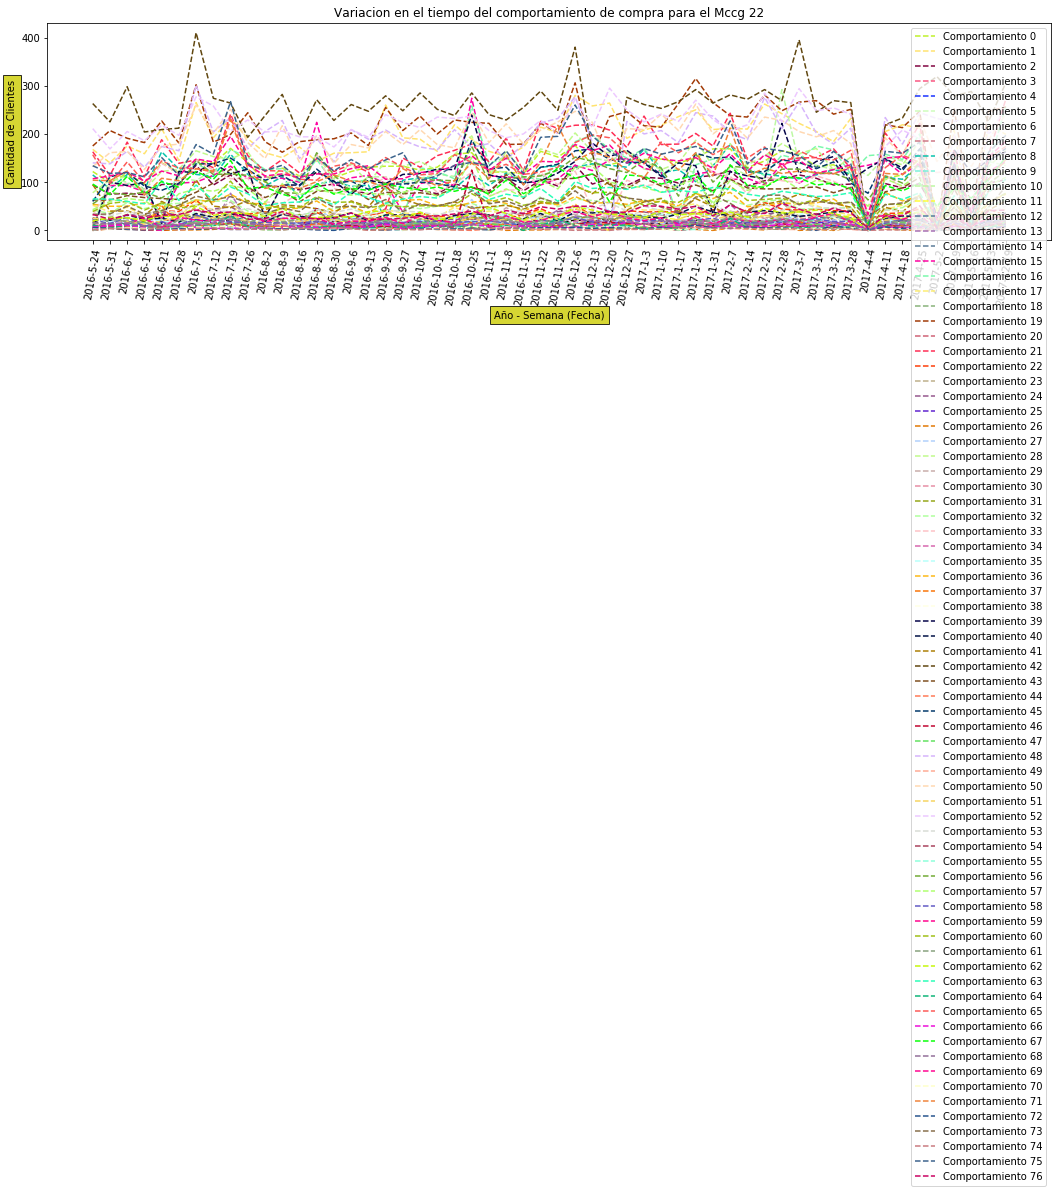

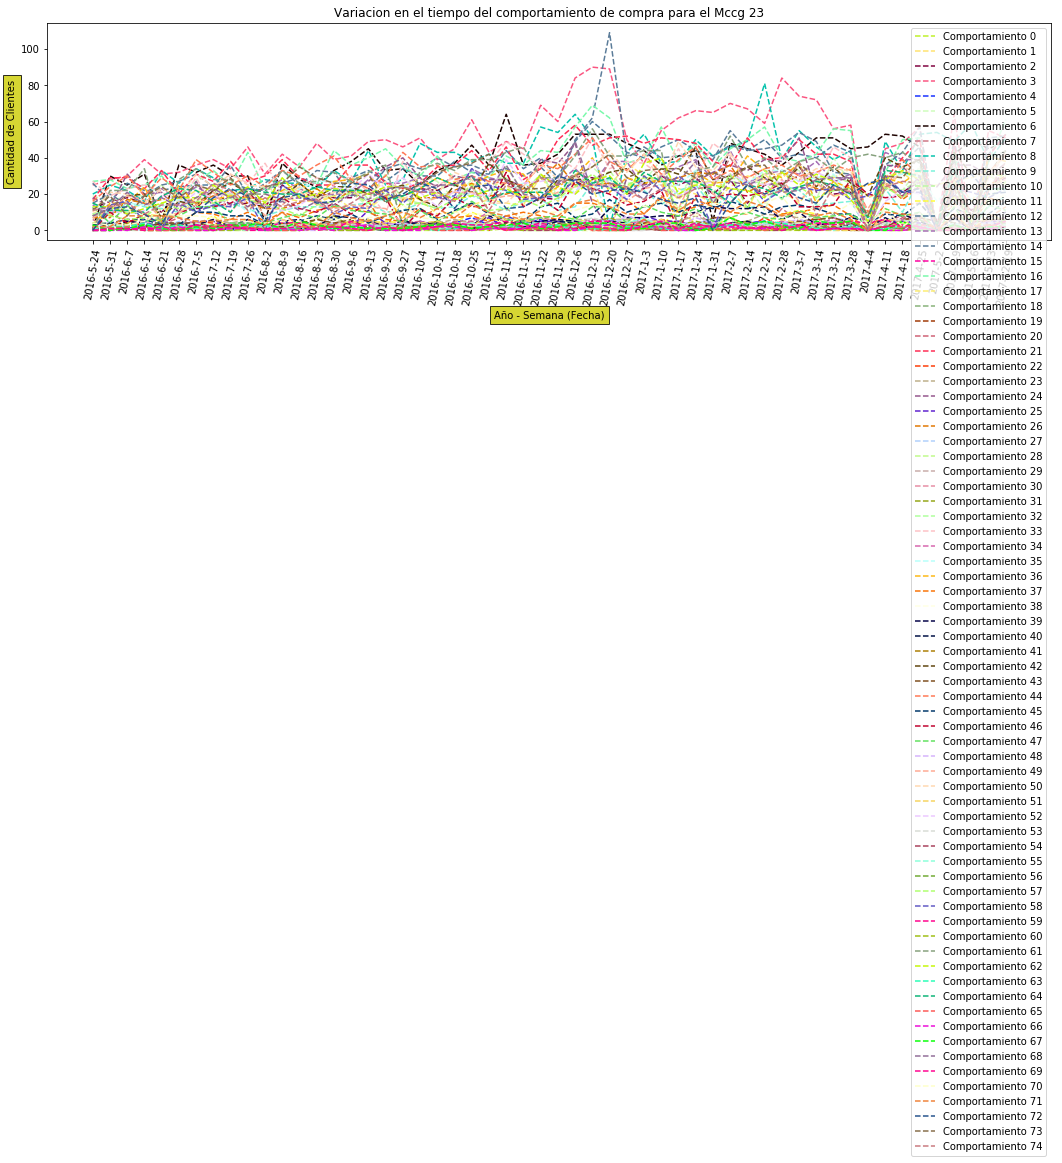

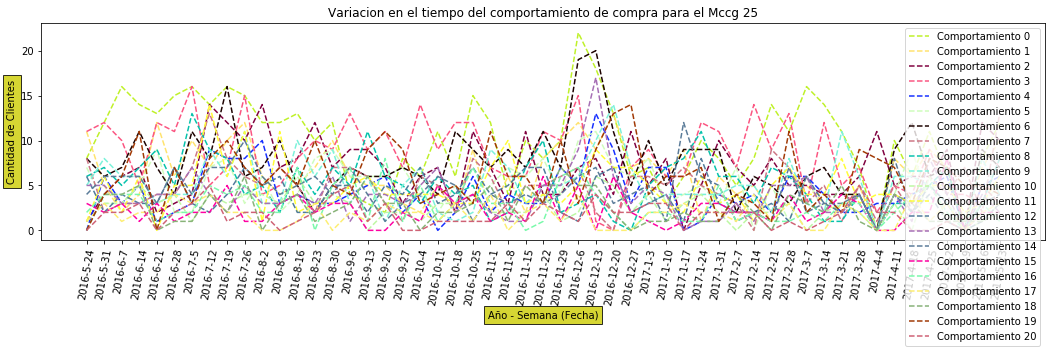

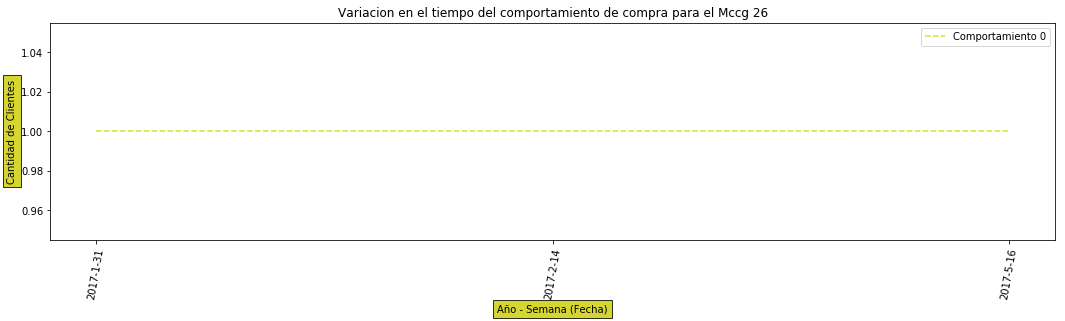

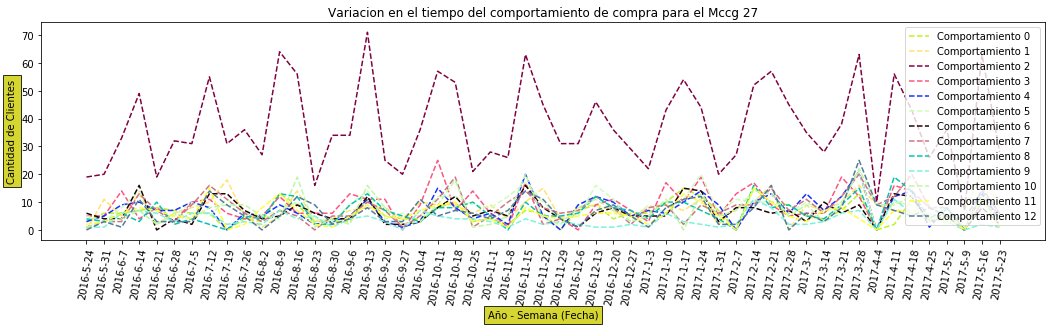

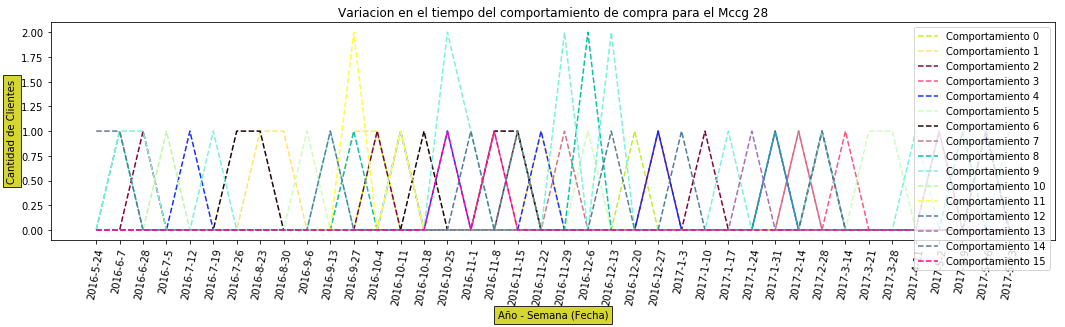

In [16]:
from datetime import datetime
def fromisocalendar(y,w,d):
    date = datetime.strptime( "%04dW%02d-%d"%(y,w-1,d), "%YW%W-%w")
    aa = date.year
    mm = date.month
    dd = date.day
    return str(aa)+"-"+str(mm)+"-"+str(dd) 

import matplotlib._color_data as mcd
box = dict(facecolor='#cccc00', pad=4, alpha=0.8)

for i in range(len(mccg)):
#for i in range(1):

    path = "RESULTS/MCCG_"+str(mccg[i])
    path_res='./%s/mccg_%s_results.csv.json' %(path,mccg[i])
    
    result = pd.read_csv(path_res, sep=",", header=0)
    
    hist = result.groupby(['collective_cluster'], as_index=False, sort=True)['customer_tag'].count()
    longitud = len(hist)
    helper = result.groupby(['year','week','collective_cluster'], as_index=False, sort=True)['customer_tag'].count()
    helper['fecha'] = helper['year'].astype(str).str.cat(helper['week'].astype(str), sep='-')
    helper = helper[['fecha','collective_cluster','customer_tag']]
    helper_1 = helper.groupby(['fecha']).count()
    helper_1['fecha'] = helper_1.index
    
    fig = plt.figure(figsize=(18,4))
    ax = fig.add_subplot(111, frameon=True)
    x = list(helper['fecha'].drop_duplicates())
    x1 = x
    for j in range(len(x)):
        x1[j] = fromisocalendar(int(x[j][:4]),int(x[j][5:len(x[j])]),2)

        
    ax.set_xticklabels(x, rotation=80)

    # ------------ COLORES ---------------------
    overlap = mcd.XKCD_COLORS
    colores = ["" for x in range(len(overlap))]
    for j, n in enumerate(sorted(overlap, reverse=True)):
        cor = mcd.XKCD_COLORS[n].upper()
        colores[j] = cor

    legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

    from datetime import datetime

    for k in range(longitud):
        cluster_k = helper[helper['collective_cluster']==k]
        cluster_k1 = helper_1.set_index('fecha').join(cluster_k.set_index('fecha'), lsuffix='_x', rsuffix='_y')
        cluster_k1 = cluster_k1[['customer_tag_y']]
        cluster_k1 = cluster_k1.fillna(0)
        y = cluster_k1['customer_tag_y']
        #x = cluster_k1.index
        ax.plot(x,y,'--',color=colores[k*9],label="Comportamiento "+str(k))

    
    
    ax.legend()
    title = 'Variacion en el tiempo del comportamiento de compra para el Mccg '+str(mccg[i])
    ax.set_title(title)
    ax.set_xlabel('Año - Semana (Fecha)', bbox=box)
    ax.set_ylabel('Cantidad de Clientes', bbox=box)

print('Done')

/home/jkn/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/jkn/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/jkn/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed an

/home/jkn/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/jkn/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/jkn/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed an

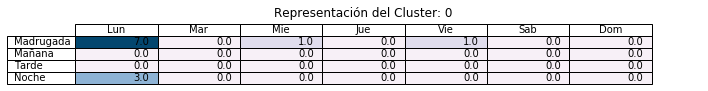

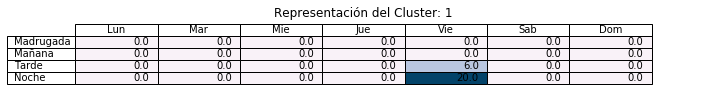

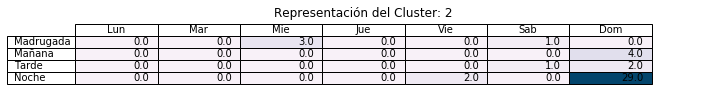

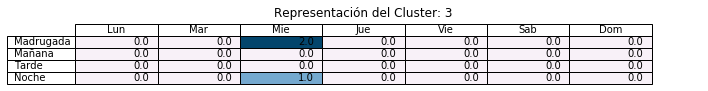

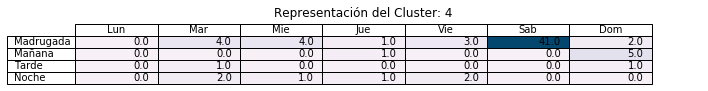

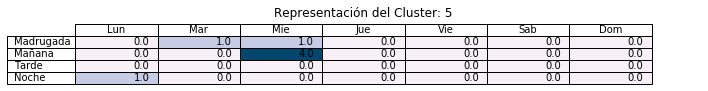

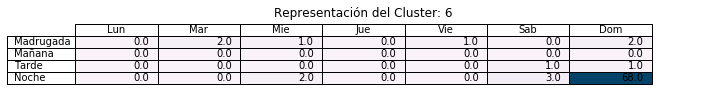

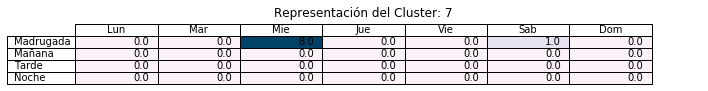

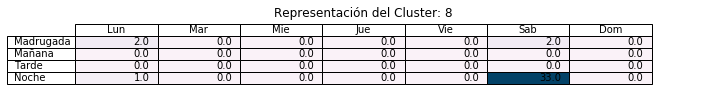

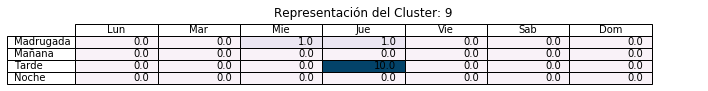

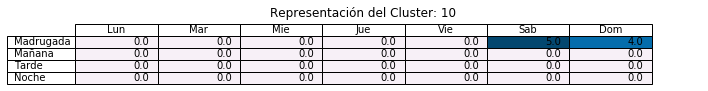

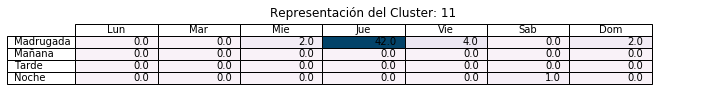

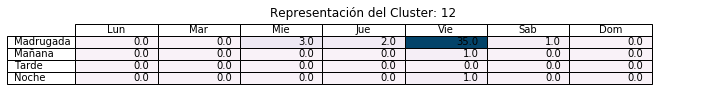

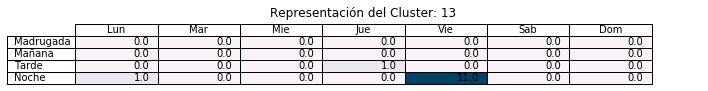

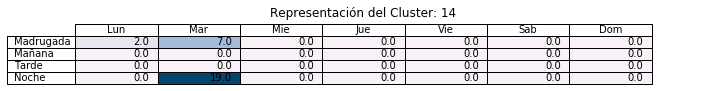

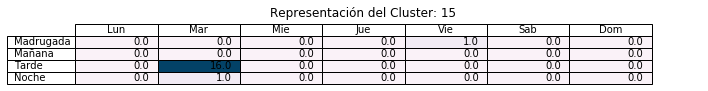

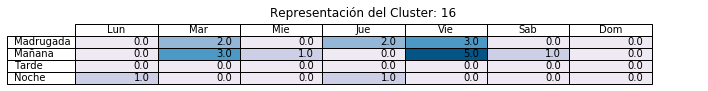

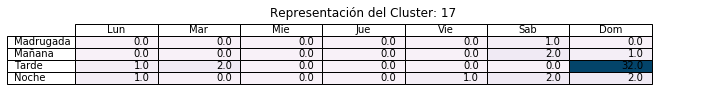

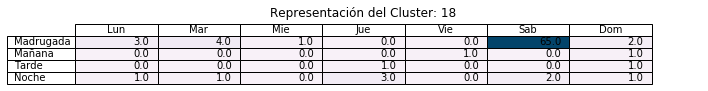

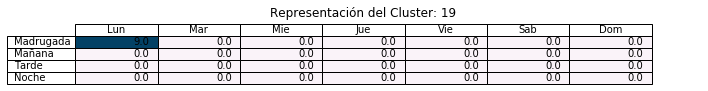

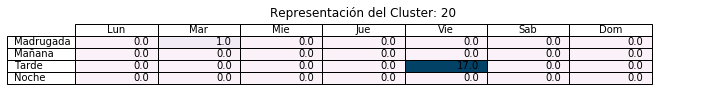

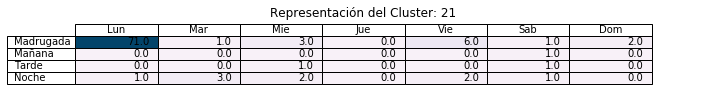

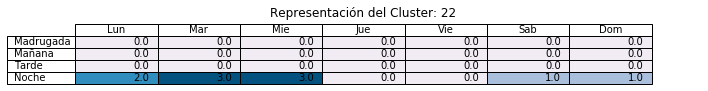

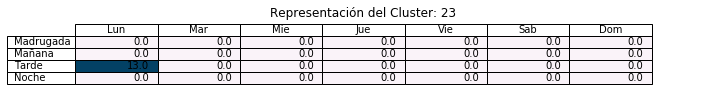

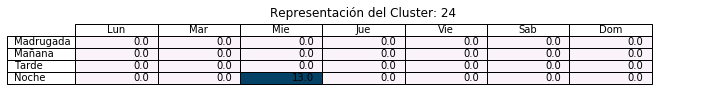

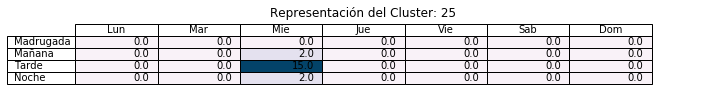

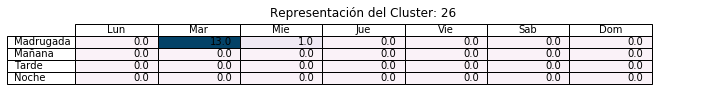

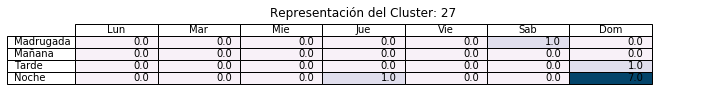

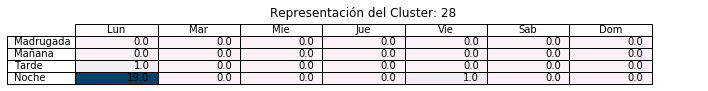

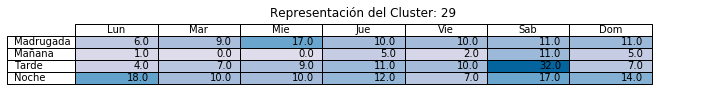

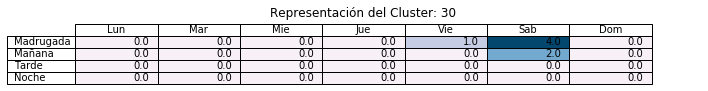

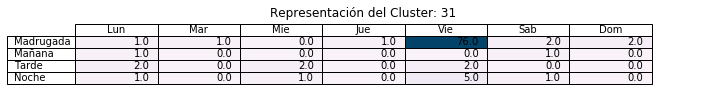

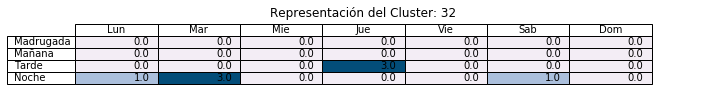

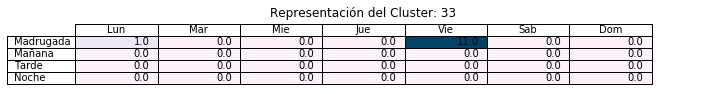

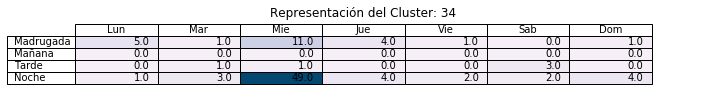

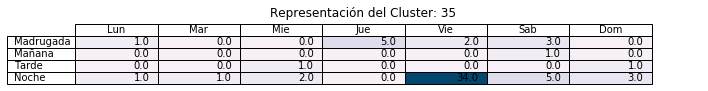

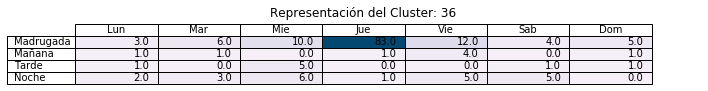

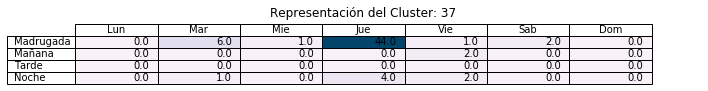

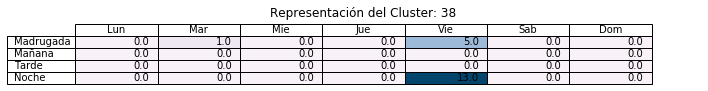

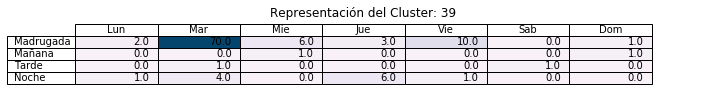

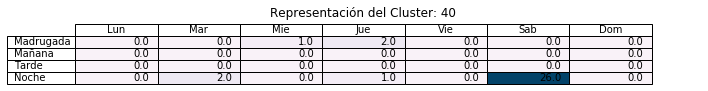

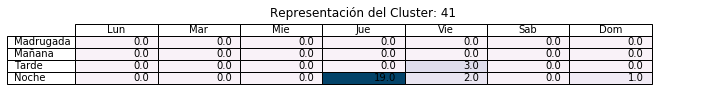

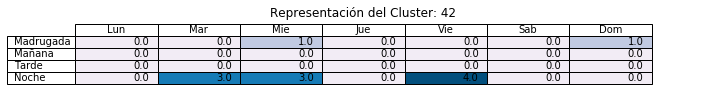

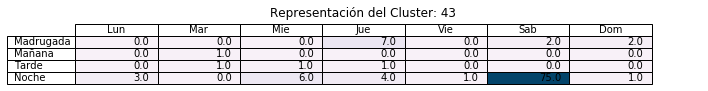

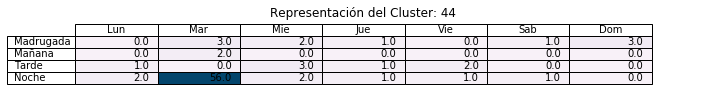

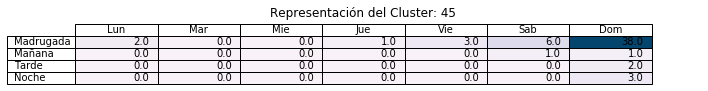

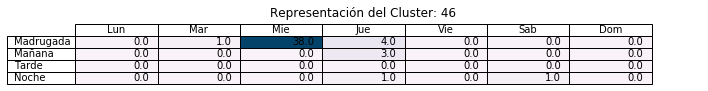

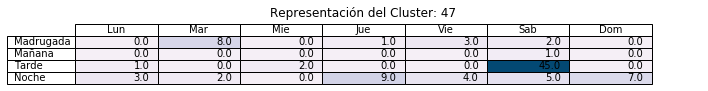

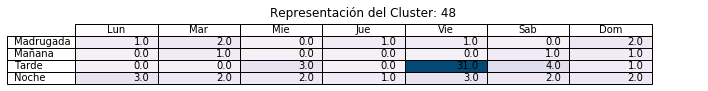

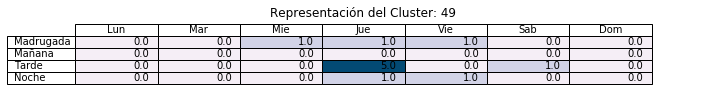

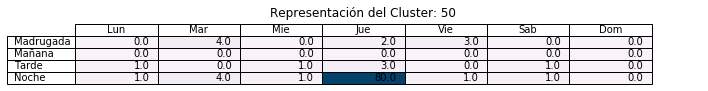

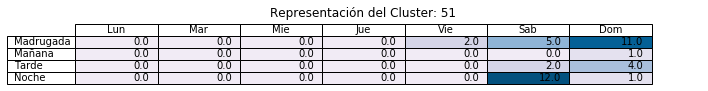

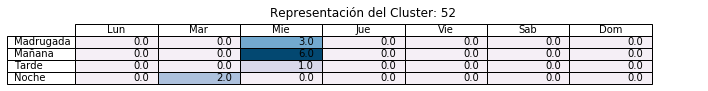

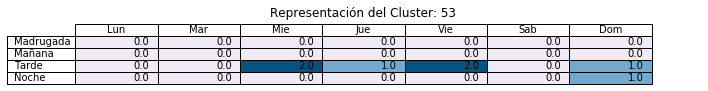

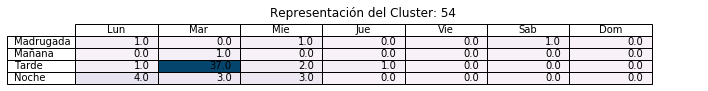

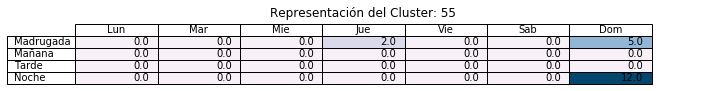

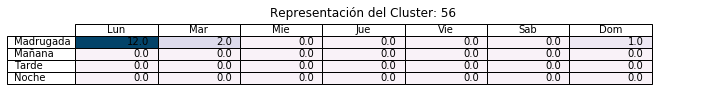

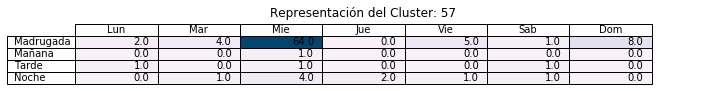

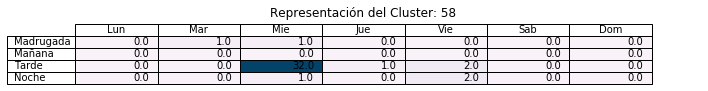

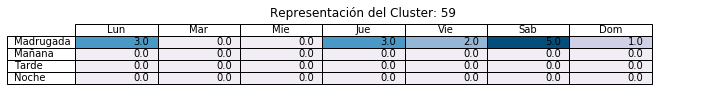

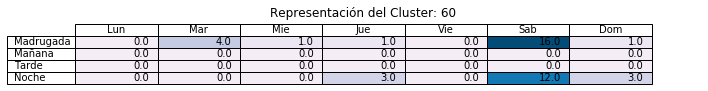

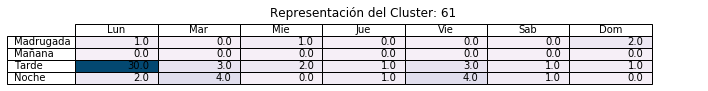

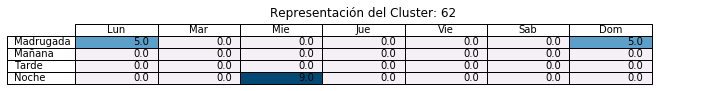

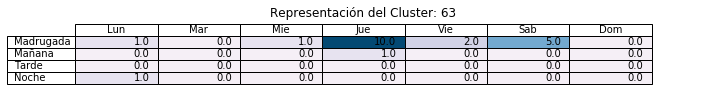

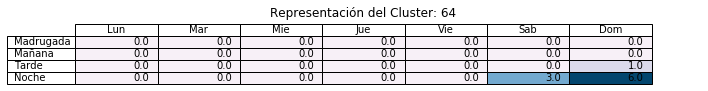

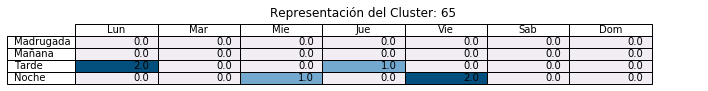

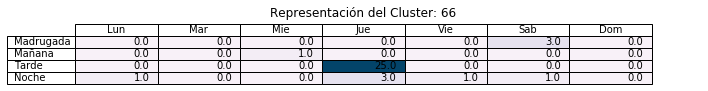

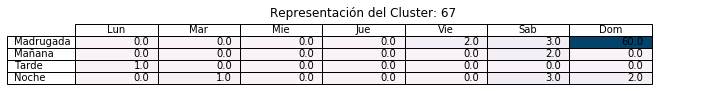

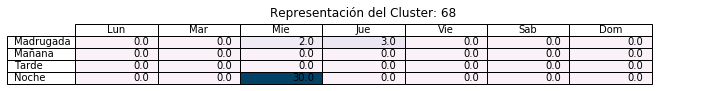

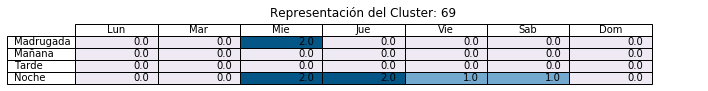

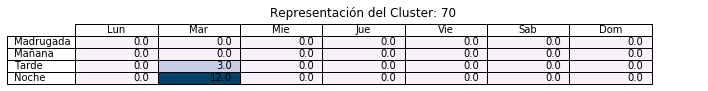

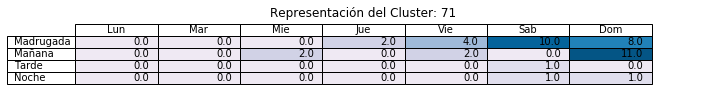

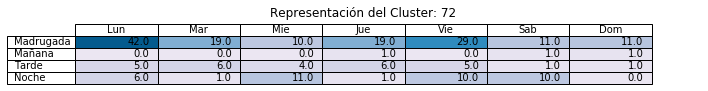

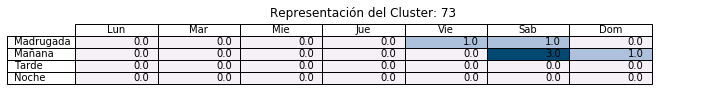

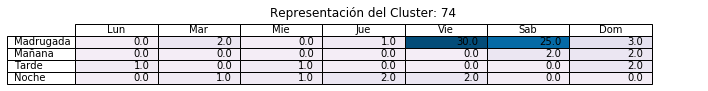

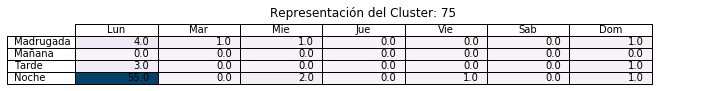

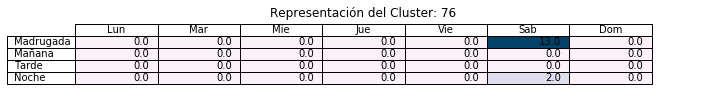

In [17]:
mccg_deseado = 2

# for i

path = "RESULTS/MCCG_"+str(mccg_deseado)
path_res='./%s/mccg_%s_results.csv.json' %(path,mccg_deseado)
    
result = pd.read_csv(path_res, sep=",", header=0)

# Numero de cluster
cluster = result.groupby(['collective_cluster']).sum()
cluster = cluster.iloc[:, 5:-1]
num_cluster= len(cluster)

for j in range(num_cluster):
    cluster_i = cluster[cluster.index == j]
    df0 = cluster_i.iloc[:, 0:7] 
    df1 = cluster_i.iloc[:, 7:14]
    df2 = cluster_i.iloc[:, 14:21]
    df3 = cluster_i.iloc[:, 21:28]

    df0 = df0.transpose().reset_index(drop=True).transpose()
    df1 = df1.transpose().reset_index(drop=True).transpose()
    df2 = df2.transpose().reset_index(drop=True).transpose()
    df3 = df3.transpose().reset_index(drop=True).transpose()

    dfs = [df0,df1,df2,df3]
    df = pd.concat( dfs,axis=0,ignore_index=True)
    df.columns = ['Lun','Mar', 'Mie','Jue','Vie','Sab','Dom']
    df.index = ['Madrugada','Mañana', 'Tarde','Noche']
    
    m = np.around(df.values,2)
    vals = np.around(df.values/(cluster_i.values).mean(),2)
    normal = plt.Normalize(vals.min()-1, vals.max()+1)

    fig = plt.figure(figsize=(12,1))
    
    ax = fig.add_subplot(111, frameon=False, xticks=[], yticks=[])
    ax.set_title('Representación del Cluster: %s'%(j))
    the_table=plt.table(cellText=m, rowLabels=df.index, colLabels=df.columns, 
                        colWidths = [0.123]*vals.shape[1], loc='upper center', 
                        cellColours=plt.cm.PuBu(normal(vals)))